# 1. Data Background and Problem Formulation

In this project, a dataset is given with 900+ data each corresponding to individual indicators of users' experience surveys revolving around proposed system designs -- and how would potential users react or perceive this notion. 

The goal is to provide a deep learning model with an acceptable rate of AUC (0.7 to 0.9) on test dataset in order to be able to predict certain words clearly.

To gain a better sense of the data, we first import the necessities to run the overall code.

---


In [1]:
# Configure output settings to prettify print display

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
# Ignore warnings to prettify print

import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install scikit-multilearn
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imblearn

You should consider upgrading via the 'c:\users\chari\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 1.1. Importing the data
We can then import the data via `pandas` package to see the overall nature of the data, the outputs, and the datatypes.

In [5]:
df = pd.read_excel('Sample.xlsx', sheet_name='PROMISE-Extended_Ivan33')
df.drop(columns=['ID', 'ProjectID', 'Class'], axis=1, inplace=True)
df.sample(n=10, random_state=1)

Requirements  \
718  Secure data transfer over the Internet could b...   
637  The system shall validate the amount is availa...   
759  Sensitive data will be encrypted before being ...   
366  PME Subsystem shall allow building product men...   
543  The system shall be responsive. At the DePaul ...   
41   The product shall synchronize with the office ...   
120  Program Administrators and Nursing Staff Membe...   
725  It must be able to download the most recent me...   
795  Customer must logout of the site after purchas...   
672  Changes made to the Manage My ID website can b...   

     obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
718                          7                    5                         6   
637                          7                    6                         7   
759                          7                    6                         7   
366                          5                    4                         6   
543                          6                    6                         7   
41                           5                    5                         5   
120                          6                    5                         6   
725                          6                    7                         6   
795                          3                    2                         3   
672                          4                    3                         4   

      confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
718                    6                   3                               4   
637                    7                   2                               3   
759                    7                   4                               4   
366                    5                   3                               4   
543                    7                   5                               6   
41                     5                   5                               4   
120                    5                   5                               4   
725                    7                   3                               4   
795                    2                   1                               2   
672                    3                   3                               4   

     conventional<==>inventive  usual<==>leading edge  
718                          3                      3  
637                          1                      1  
759                          2                      3  
366                          4                      4  
543                          3                      4  
41                           4                      5  
120                          3                      2  
725                          3                      3  
795                          4                      6  
672                          4                      5

In [6]:
data=df.copy()
df.columns

Index(['Requirements', 'obstructive<==>supportive', 'complicated<==>easy',
       'inefficient<==>efficient', ' confusing<==>clear', 'boring<==>exciting',
       'not interesting<==>interesting', 'conventional<==>inventive',
       'usual<==>leading edge'],
      dtype='object')

In [7]:
data['mix']=data['obstructive<==>supportive']+data['complicated<==>easy']+data['inefficient<==>efficient']+data[' confusing<==>clear']+data['boring<==>exciting']+data['not interesting<==>interesting']+data['conventional<==>inventive']+data['usual<==>leading edge']

In [8]:
data.head()

Requirements  \
0  The system shall refresh the display every 60 ...   
1  The application shall match the color of the s...   
2  If projected  the data must be readable.  On a...   
3  The product shall be available during normal b...   
4  If projected  the data must be understandable....   

   obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
0                          3                    4                         3   
1                          7                    2                         5   
2                          7                    4                         7   
3                          7                    2                         7   
4                          7                    2                         7   

    confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
0                    3                   4                               3   
1                    5                   3                               3   
2                    7                   5                               5   
3                    5                   5                               5   
4                    7                   5                               7   

   conventional<==>inventive  usual<==>leading edge  mix  
0                          6                      6   32  
1                          6                      6   37  
2                          5                      4   44  
3                          5                      6   42  
4                          3                      3   41

## 1.2. Column Definitions
### 1.2.1. Features

Features are only represented in the first column, which is the `Requirements` column. This column represents the question and/or the funcionalities of the system itself.

### 1.2.2. Labels

Labels, on the other hand, comprised of 8 columns in total. They are:
* **obstructive<==>supportive**, measuring supportiveness.
* **complicated<==>easy**, measuring ease-of-use.
* **inefficient<==>efficient**, measuring efficiency.
* **confusing<==>clear**, measuring brevity and clarity.
* **boring<==>exciting**, measuring excitement.
* **not interesting<==>interesting**, measuring appeal.
* **conventional<==>inventive**, measuring innovation.
* **usual<==>leading edge**, measuring technology usage.

The scales on the labels vary from 1 to 7, in which values closer to 1 corresponds to a more negative connotation, while values closer to 7 is likely to be more positive.

For example, for column `boring<==>exciting`, if a user gives it a 3, whilst this may seem neutral at first glance, we can infer that the user does not regard this system design as easy-to-use -- otherwise they would give it a score of 5 or 6.

For this task, we'll run multiclass multilabel regression since we obtained a good AUC with multiclass regression on one column before with simple regression. **The trick here is to not use a single column.**

With this, we might want to approach the problem within the scope of [Multi-output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)

First, we separate the labels from the data.

In [9]:
features = df.iloc[:, 0].values # First column in the entire set
labels = df.iloc[:, np.r_[1:9]].values
print("Features is now of type:", type(features), "with shape", features.shape)
print("Labels is now of type:", type(labels), "with shape", labels.shape)

Features is now of type: <class 'numpy.ndarray'> with shape (969,)
Labels is now of type: <class 'numpy.ndarray'> with shape (969, 8)


We know from previous work that the dataset is very much imbalanced, so we would want to try oversampling across all columns and make them our new label. But first, we would want to convert features as word vectors first.

## 1.3. Quick EDA

We can visualize the most used words via `wordcloud` used in our dataset.

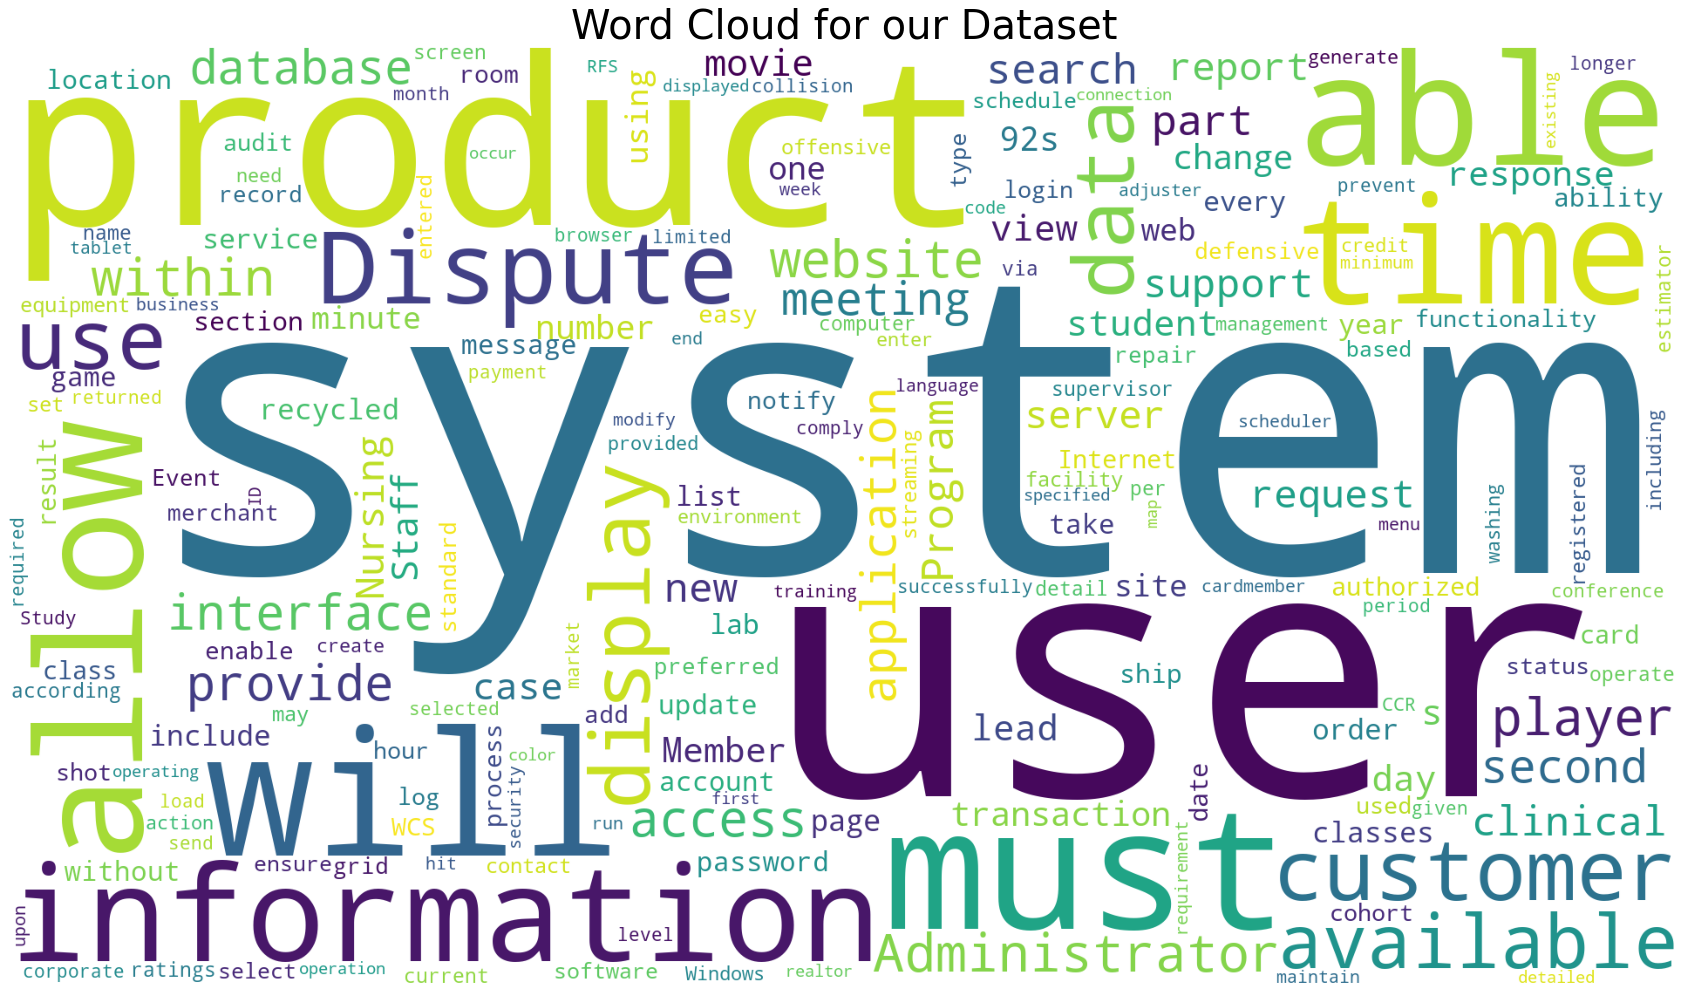

In [10]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,20))
text =df['Requirements'].values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1920,
                          height=1080
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Word Cloud for our Dataset",fontsize=40)
plt.imshow(cloud)

In [11]:
from collections import Counter
for i in range(8):
  print("Column:", df.columns[1:][i])
  print(Counter(labels[:,i]))

Column: obstructive<==>supportive
Counter({7: 418, 6: 281, 5: 152, 4: 63, 3: 37, 2: 16, 1: 2})
Column: complicated<==>easy
Counter({6: 278, 5: 254, 7: 210, 4: 144, 3: 57, 2: 24, 1: 2})
Column: inefficient<==>efficient
Counter({7: 406, 6: 306, 5: 128, 4: 71, 3: 36, 2: 18, 1: 4})
Column:  confusing<==>clear
Counter({7: 443, 6: 245, 5: 148, 4: 68, 3: 38, 2: 23, 1: 4})
Column: boring<==>exciting
Counter({3: 256, 4: 249, 5: 185, 2: 142, 6: 89, 7: 26, 1: 22})
Column: not interesting<==>interesting
Counter({4: 265, 3: 245, 5: 222, 2: 103, 6: 92, 7: 23, 1: 19})
Column: conventional<==>inventive
Counter({3: 273, 2: 267, 4: 164, 5: 102, 1: 101, 6: 55, 7: 7})
Column: usual<==>leading edge
Counter({3: 259, 2: 253, 4: 177, 5: 112, 1: 101, 6: 61, 7: 6})


# 2. Pre-processing
---

## 2.1. Tokenization

Tokenization means splitting each word and vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary). This process cleans up our text, lowercase, and remove punctuations. This step is basically the same from our previous work involving LSTMs.

This way, we can see which words appear the most in our training set.

In [12]:
tokenizer = Tokenizer(num_words = 2000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'the': 2,
 'shall': 3,
 'to': 4,
 'system': 5,
 'of': 6,
 'be': 7,
 'a': 8,
 'and': 9,
 'product': 10}

After tokenization, the next step is to turn those tokens into lists of sequence.

In [13]:
sequences = tokenizer.texts_to_sequences(features)
print(sequences[0]) # This corresponds to the first sentence in the training data.

[2, 5, 3, 674, 2, 32, 96, 675, 49]


## 2.2. Padding

When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Padding means that we convert all instances of the training data towards the same size. To do this, we need to specify a fixed length to transform all the instances on.

For the project, we can set the sequence by looking quickly at the average proportion of the training words.

In [14]:
import math
word_counts = []
for i in (features):
  word_counts.append(len(i.split(" ")))
print("Average word counts:" , sum(word_counts)/len(word_counts))

# Round max length of padding to the nearest tenth
max_length = math.ceil((sum(word_counts)/len(word_counts))/10) * 10
print("Padded onto length: ", max_length)

# Delete unused variable
del word_counts 

Average word counts: 18.223942208462333
Padded onto length:  20


We can then proceed to do the actual padding. This is done for all instances of the training example.

In [15]:
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

for i in range(5):
  print("Sequence of length", len(sequences[i]), "was padded onto", len(padded[i]))

Sequence of length 9 was padded onto 20
Sequence of length 16 was padded onto 20
Sequence of length 29 was padded onto 20
Sequence of length 36 was padded onto 20
Sequence of length 35 was padded onto 20


In [16]:
padded

array([[  2,   5,   3, ...,   0,   0,   0],
       [  2,  45,   3, ...,   0,   0,   0],
       [ 69, 879,   2, ...,  17,   4, 451],
       ...,
       [  2,   1,  36, ...,  91, 309,  12],
       [  2,   5,   3, ...,   9, 102,   4],
       [  2,  36,  15, ..., 304,  15,   7]])

## 2.3. SMOTE Oversampling

Generally, oversampling makes fake data so that the minority labels are not squashed by the majority.

Constraint of using SMOTE within this dataset is that it's very fragile to classes with only one example. Since SMOTE works via k-nearest neighbors, at least two members of a class would be mandatory for it to work.

Synthetic samples generated with respect to the most amount of classes in all columns so that input shape (features and labels) are consistent against each other.

## REVISION: ROS Oversampling

ROS generates random data as opposed to the better, more superior SMOTE which generates "more credible" data. We can't use SMOTE on all sheets because of the `n_neighbors` and distance constraint.

We find the least common multiple of all class members amount, and oversample from there to get the matrix dimensions uniform.

In [17]:
import copy
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
max_amount = np.lcm.reduce([1,2,3,4,5,6,7]) * 40
labels_processed = np.zeros((max_amount, 8))

for i in range(8):
  unique_classes = np.unique(df[df.columns[1:][i]])
  amount = [int(
      (max_amount/len(unique_classes)))
      ] * len(unique_classes)
  x = {k:v for (k,v) in zip(unique_classes, amount)}
  smt = RandomOverSampler(sampling_strategy=x)
  X, y = smt.fit_resample(padded, labels[:,i])
  labels_processed[:,i] = y
  print("Column", i, "done.")
  # We don't save nor use the X variable between each iteration, 
  # instead only using the last one.


print("Shape of input features is:", X.shape)
print("Shape of labels is:",labels_processed.shape)

Column 0 done.
Column 1 done.
Column 2 done.
Column 3 done.
Column 4 done.
Column 5 done.
Column 6 done.
Column 7 done.
Shape of input features is: (16800, 20)
Shape of labels is: (16800, 8)


In [18]:
# Sanity check time!
for i in range(8):
  print("For column", df.columns[1:][i])
  print(Counter(labels_processed[:,i]),"\n------")


print("First ten entries of the processed labels:\n", labels_processed[:10,:])
print("First ten entries of the processed features:\n", X[:10,:])

# Last and final assertion to catch matrix errors
try:
  assert(X.shape[0] == labels_processed.shape[0])
  print("Assertion completed!")
except AssertionError:
  print("Error!\nShape of X is", X.shape, "while labels is", labels_processed.shape)
  raise AssertionError

For column obstructive<==>supportive
Counter({3.0: 2400, 7.0: 2400, 5.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column complicated<==>easy
Counter({4.0: 2400, 2.0: 2400, 3.0: 2400, 6.0: 2400, 1.0: 2400, 5.0: 2400, 7.0: 2400}) 
------
For column inefficient<==>efficient
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column  confusing<==>clear
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 1.0: 2400, 4.0: 2400, 2.0: 2400}) 
------
For column boring<==>exciting
Counter({4.0: 2400, 3.0: 2400, 5.0: 2400, 2.0: 2400, 6.0: 2400, 7.0: 2400, 1.0: 2400}) 
------
For column not interesting<==>interesting
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 4.0: 2400, 6.0: 2400, 2.0: 2400, 1.0: 2400}) 
------
For column conventional<==>inventive
Counter({6.0: 2400, 5.0: 2400, 3.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400, 7.0: 2400}) 
------
For column usual<==>leading edge
Counter({6.0: 2400, 4.0: 2400, 3.0: 2400, 2.0: 2400, 5.0: 

## 2.4. Train-test Splitting

Finally we get to this part. We can use sklearn's `train_test_split` to do the usual splitting for test set (validation set is specified within building the model in the next section).

Also, specifying `random_state` ensures reproducibility.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


In [20]:
data = {'metric':['Accuracy', 'Precision', 'Recall', 'F1 Score','RMSE','AUC score']}
metric_df=pd.DataFrame(data)

In [21]:
metric_df.set_index(['metric'])


Empty DataFrame
Columns: []
Index: [Accuracy, Precision, Recall, F1 Score, RMSE, AUC score]

In [22]:
from keras import backend
 
def rmse(y_true, y_pred):
   return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
 

# 3. Modelling

## 3.1. Building the Model

Since we're training on augmented data, we're going to approach this as conventional regression compared to the LSTM approach we're doing it before.

LSTM model in this manner would result in a pretty bad metric score (around 0.5 to 0.7 F1-score) whereas our fully-connected dense layers resulted in a pretty satisfying F1, which is around 0.8 to 1 for each column.

In [23]:
# Wrapper functions for result interpretation
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def transform_results(estimates):
  res = []
  for x in estimates:
    if x > 7:
      x = 7
      res.append(x)
    else:
      res.append(x)
  return res

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[rmse], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)             

Epoch 1/150
588/588 - 3s - loss: 4.2830 - rmse: 1.7088 - val_loss: 2.2298 - val_rmse: 1.1961
Epoch 2/150
588/588 - 2s - loss: 2.0842 - rmse: 1.2093 - val_loss: 1.5558 - val_rmse: 1.0159
Epoch 3/150
588/588 - 2s - loss: 1.5607 - rmse: 1.0260 - val_loss: 1.2513 - val_rmse: 0.9187
Epoch 4/150
588/588 - 2s - loss: 1.3327 - rmse: 0.9273 - val_loss: 1.0561 - val_rmse: 0.7893
Epoch 5/150
588/588 - 2s - loss: 1.2016 - rmse: 0.8669 - val_loss: 0.9431 - val_rmse: 0.7390
Epoch 6/150
588/588 - 2s - loss: 1.0847 - rmse: 0.8068 - val_loss: 0.9091 - val_rmse: 0.7007
Epoch 7/150
588/588 - 2s - loss: 1.0149 - rmse: 0.7691 - val_loss: 0.9400 - val_rmse: 0.7589
Epoch 8/150
588/588 - 2s - loss: 0.9747 - rmse: 0.7464 - val_loss: 0.7939 - val_rmse: 0.6596
Epoch 9/150
588/588 - 2s - loss: 0.9280 - rmse: 0.7205 - val_loss: 0.8100 - val_rmse: 0.6611
Epoch 10/150
588/588 - 2s - loss: 0.8835 - rmse: 0.6978 - val_loss: 0.8672 - val_rmse: 0.7324
Epoch 11/150
588/588 - 3s - loss: 0.8561 - rmse: 0.6797 - val_loss: 0

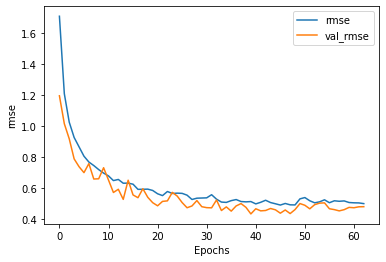

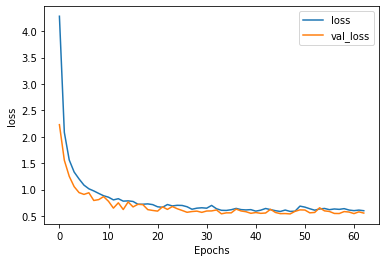

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "rmse")
plot_graphs(history, "loss")

## 3.2. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

Resulted on a pretty confident `mae` and `mse`, which I would say a good result considering the number of classes we have.

In [26]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 5s 2ms/step - loss: 0.5735 - rmse: 0.4815
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 57.35%
rmse: 48.15%


We can also print classification report from each column.

## 3.3. Prepare the Plotting Set

Due to the multi-dimensional nature of our results and test set, we need to reshape the predictions by using `numpy`'s `flatten()` attribute, which flattens the array column-wise if we specify the argument `order='F'` to flatten in Fortran-style order.

Keep in mind this will indeed aggregate the metrics like on the `classification_report()` below.

In [27]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_flattened = y_pred.flatten(order='F')
y_test_flattened = y_test.flatten(order='F')
y_classified = [round(float(x)) for x in y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [3, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.94      0.91      0.93      3691
         2.0       0.76      0.58      0.66      3921
         3.0       0.58      0.70      0.63      3952
         4.0       0.69      0.74      0.71      4161
         5.0       0.74      0.78      0.76      3786
         6.0       0.69      0.84      0.76      3748
         7.0       0.93      0.67      0.78      3621

    accuracy                           0.74     26880
   macro avg       0.76      0.74      0.75     26880
weighted avg       0.76      0.74      0.74     26880



In [28]:
# Wrapper function(s) from earlier notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

avgroc=dict()

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
  """
  Modified function behavior, now predicts column-wise
  """
  y_score = clf.predict_proba(X_test)
  target_names = np.unique(y_test)
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # calculate dummies once
  y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
  print(y_test_dummies.shape, y_score.shape)
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic')
    
  for i in range(len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

  return fpr,tpr

def plot_multiclass_roc_LSTM(X_test, y_test, n_classes, figsize=(17, 6), model=model):
  """
  Custom-made function to plot ROC curve.
  Sorry I can't run because I don't have the excel file used for this particular notebook.
  """
  y_score = to_categorical(y_test)
  target_names = ["obstructive vs supportive",
                  "complicated vs easy",
                  "inefficient vs efficient",
                  " confusing vs clear",
                  "boring vs exciting",
                  "not interesting vs interesting",
                  "conventional vs inventive",
                  "usual vs leading edge"]
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # One-liner transformation of our existing result 
  y_test_dummies = np.pad(pd.get_dummies(y_classified, drop_first=False).values, 
                          ((0,0), 
                           (min(labels.flatten()),0)))
  print(y_test_dummies.shape, y_score.shape) # Quick debug purposes after one-hot encoding
                                             # to ensure matrix dimension is right
  for i in range(1, n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Column-wise Receiver Operating Characteristic Plot')
    
  for i in range(1, len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()


# plot_multiclass_roc_LSTM(X_test, y_classified, 8, figsize=(17, 6))

ROC AUC score: 0.8496986065240819


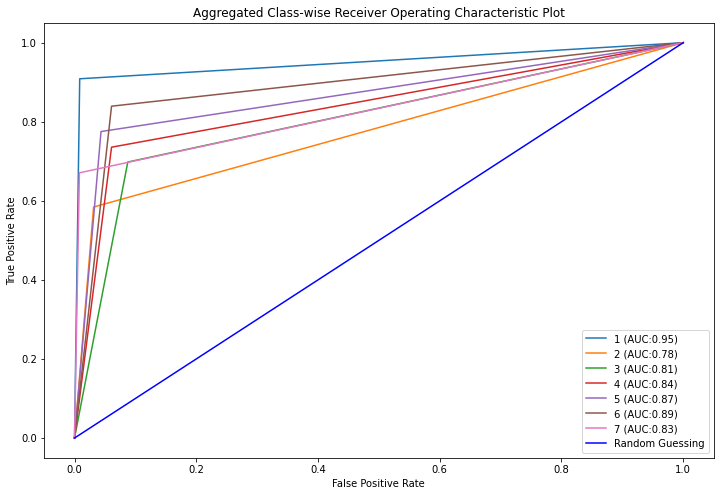

In [29]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


def score_auc(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(set(labels.flatten())):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test_flattened, y_classified))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Aggregated Class-wise Receiver Operating Characteristic Plot')
plt.savefig("auc.png")
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]

In [31]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
    print("Column", df.columns[1:][i])
    estimates = [round(float(x)) for x in y_pred[:,i]]
    estimates = transform_results(estimates)
    print(np.unique(estimates))
    acc.append(accuracy_score(y_test[:,i], estimates))
    pre.append(precision_score(y_test[:,i], estimates,average='weighted'))
    recal.append(recall_score(y_test[:,i], estimates,average='weighted'))
    f1.append(f1_score(y_test[:,i], estimates,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:,i], estimates)))
    aucscore.append(score_auc(y_test[:,i], estimates))
    print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.89      0.91       462
         2.0       0.68      0.37      0.48       482
         3.0       0.48      0.65      0.55       510
         4.0       0.60      0.67      0.63       517
         5.0       0.61      0.65      0.63       467
         6.0       0.62      0.74      0.68       470
         7.0       0.84      0.61      0.71       452

    accuracy                           0.65      3360
   macro avg       0.68      0.65      0.65      3360
weighted avg       0.67      0.65      0.65      3360
 
------
Column complicated<==>easy
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.89      0.91       463
         2.0       0.69      0.39      0.49       485
         3.0       0.48      0.67      0.56       501
         4.0       0.62      0.67      0.64       515
         5.0       0.66      0.7

In [32]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['Neural network classifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.7431175595238095
average Precision :0.7597663495961673
average Recall :0.7431175595238095
average F1 -score :0.7429156785763921
average RMSE -score :0.7589054453083661
average AUC -score :0.8496497731416077


## 3.4. Exporting the Model

We can export the model to `HDF5` format designed to store large amounts of information. More info:
* [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

In [33]:
model.save('UX_Regression.h5')

## 3.5. XGB Method
For comparison, we try implementing XGB.

For column: obstructive<==>supportive
[01:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.83      0.87      0.85       482
         3.0       0.77      0.72      0.74       510
         4.0       0.68      0.69      0.69       517
         5.0       0.65      0.66      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.80      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.78      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [ 

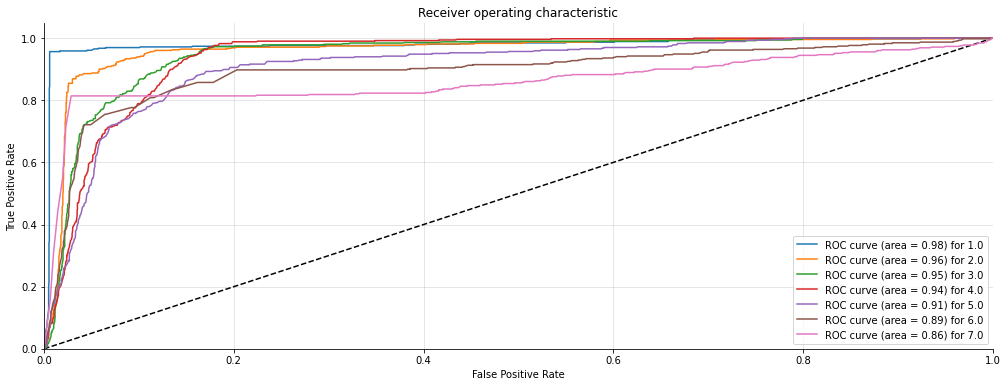

For column: complicated<==>easy
[01:24:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.83      0.87      0.85       485
         3.0       0.77      0.72      0.75       501
         4.0       0.71      0.71      0.71       515
         5.0       0.71      0.75      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  4 422

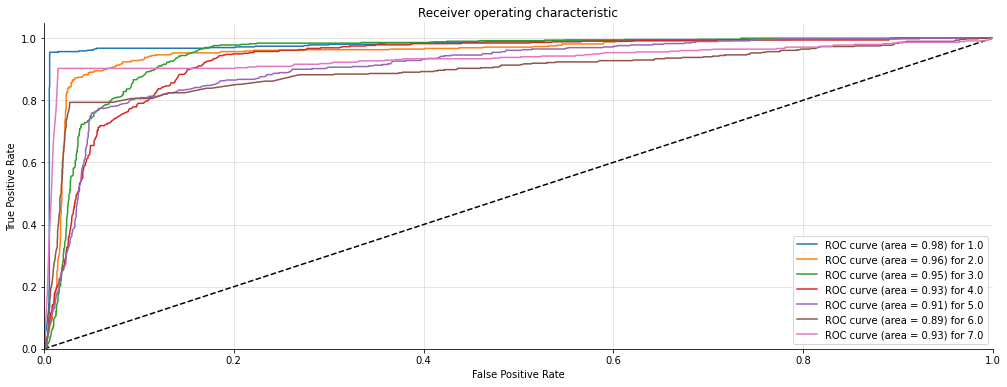

For column: inefficient<==>efficient
[01:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.83      0.87      0.85       482
         3.0       0.76      0.72      0.74       506
         4.0       0.68      0.68      0.68       526
         5.0       0.66      0.67      0.66       458
         6.0       0.72      0.71      0.71       475
         7.0       0.82      0.83      0.82       451

    accuracy                           0.77      3360
   macro avg       0.77      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  

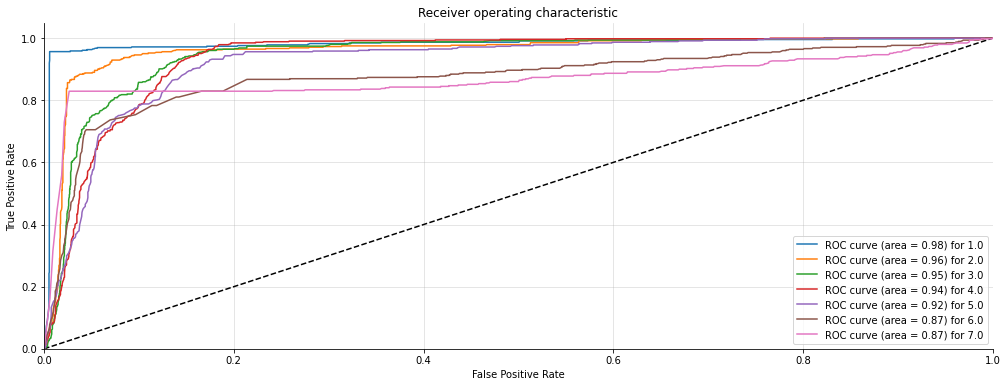

For column:  confusing<==>clear
[01:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       461
         2.0       0.83      0.86      0.84       488
         3.0       0.76      0.71      0.74       506
         4.0       0.67      0.69      0.68       516
         5.0       0.65      0.67      0.66       456
         6.0       0.73      0.72      0.72       471
         7.0       0.80      0.79      0.79       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  4 419

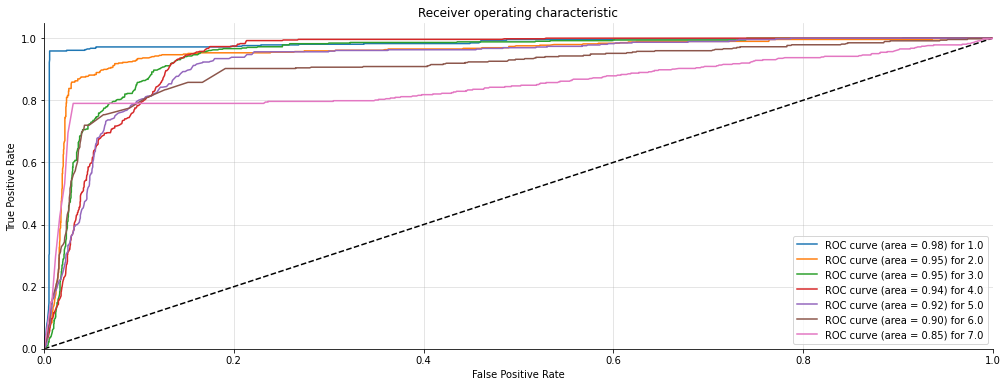

For column: boring<==>exciting
[01:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.84      0.81      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.95      0.96      0.96       462
         7.0       0.98      0.99      0.98       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 431 

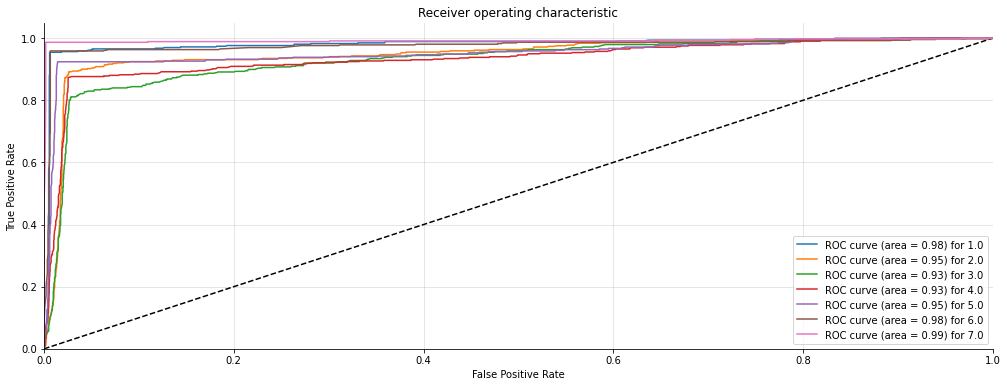

For column: not interesting<==>interesting
[01:24:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.87      0.86      0.87       495
         3.0       0.82      0.79      0.81       490
         4.0       0.83      0.84      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.98      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0

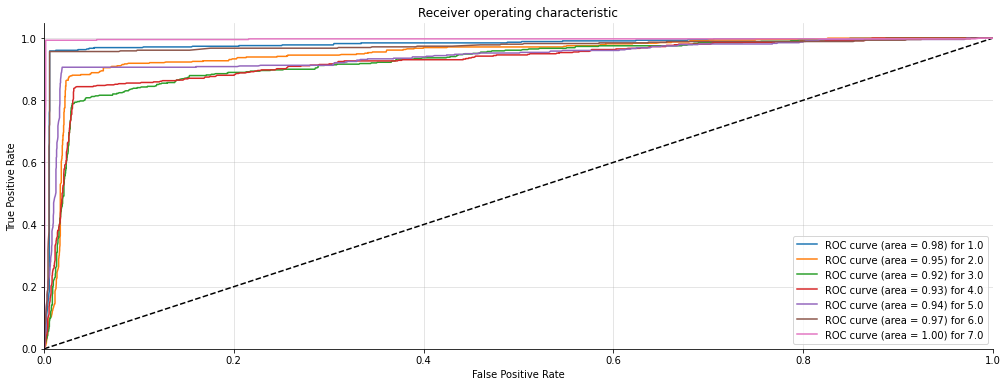

For column: conventional<==>inventive
[01:25:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [ 

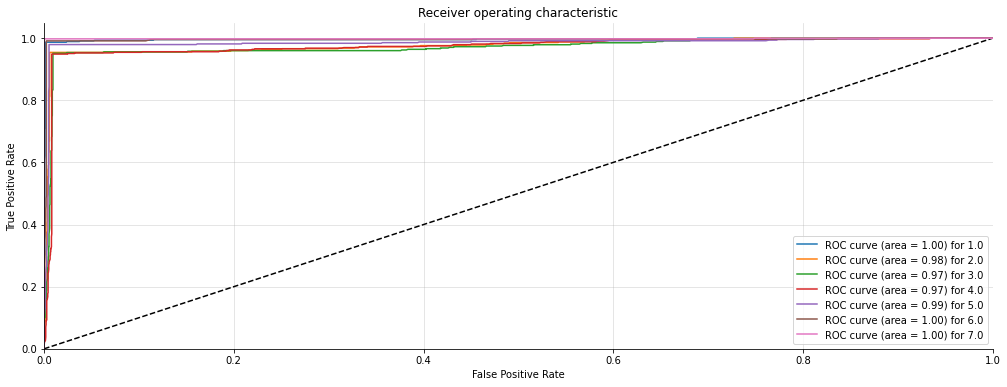

For column: usual<==>leading edge
[01:25:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 4

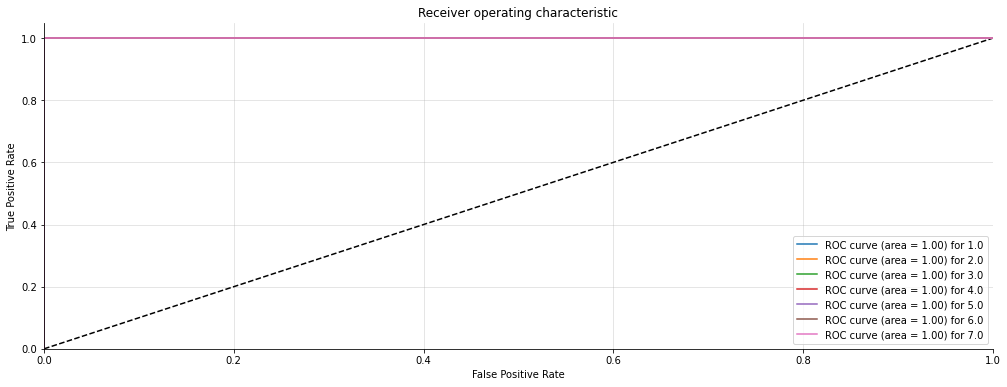

In [36]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
from operator import add



def dadd(d1,d2):
    if not d1:
        d1=d2
        return d1
    for i, j in d1.items():
       for x, y in d2.items():
           if i == x:
              temp[i]=list(map(add, j, y))
    return temp
    
    
 
        
        

    


acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
fpo=dict()
tpo=dict()
def XGBmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    xgb_classifier = XGBClassifier()
    xgb_classifier.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in xgb_classifier.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    fpo,tpo=plot_multiclass_roc(xgb_classifier, X_test, y_test, n_classes)
    
for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  XGBmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))


In [37]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['XGB'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8636532738095238
average Precision :0.8635993470183359
average Recall :0.8636532738095238
average F1 -score :0.8634966070171815
average RMSE -score :0.6159655262024647
average AUC -score :0.9202887763722234


## 3.6. SVM Method

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.49      0.92      0.64       462
         2.0       0.68      0.52      0.59       482
         3.0       0.61      0.46      0.53       510
         4.0       0.57      0.44      0.50       517
         5.0       0.54      0.39      0.45       467
         6.0       0.59      0.64      0.61       470
         7.0       0.79      0.81      0.80       452

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.59      3360

Confusion Matrix: 
 [[425  12   8   1   2  10   4]
 [111 250  60  21  15  22   3]
 [113  34 237  83  17  23   3]
 [ 82  27  39 230 104  31   4]
 [ 88  12  18  48 184 117   0]
 [ 31  19  12  10  11 302  85]
 [ 24  12  15  13   9  11 368]]
Accuracy Score : 0.594047619047619
Precision Score : 0.6071434952028743
Recall Score : 0.594047619047619
F1 Score : 0.585425060

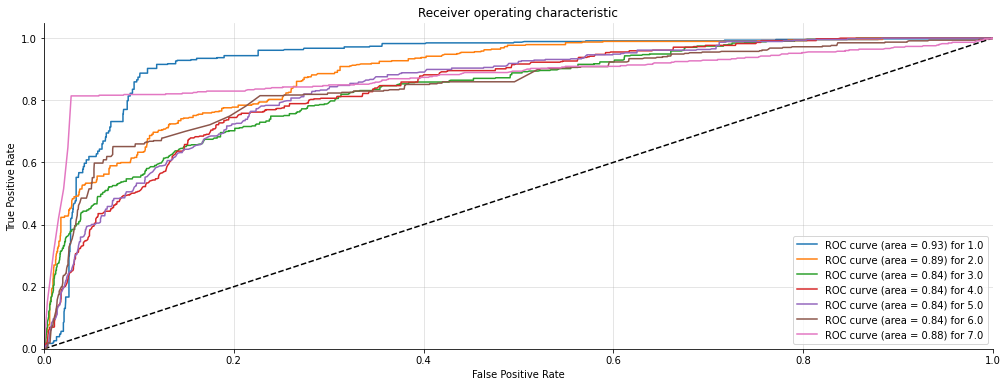

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.48      0.92      0.63       463
         2.0       0.68      0.50      0.58       485
         3.0       0.60      0.46      0.52       501
         4.0       0.56      0.43      0.48       515
         5.0       0.60      0.45      0.52       460
         6.0       0.66      0.73      0.69       484
         7.0       0.88      0.90      0.89       452

    accuracy                           0.62      3360
   macro avg       0.64      0.63      0.62      3360
weighted avg       0.63      0.62      0.61      3360

Confusion Matrix: 
 [[424  12  10   1   0  11   5]
 [113 243  60  32  11  24   2]
 [107  34 228  86  19  24   3]
 [ 93  28  36 219 102  33   4]
 [ 87  17  28  35 209  84   0]
 [ 38  17  15  12   5 353  44]
 [ 18   9   5   5   4   3 408]]
Accuracy Score : 0.6202380952380953
Precision Score : 0.6340041319584963
Recall Score : 0.6202380952380953
F1 Score : 0.6115339979773

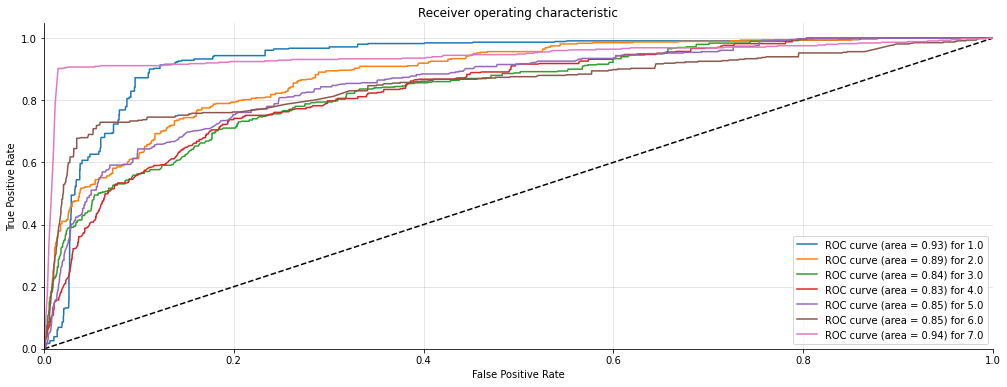

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.49      0.93      0.64       462
         2.0       0.67      0.52      0.58       482
         3.0       0.62      0.48      0.54       506
         4.0       0.57      0.41      0.48       526
         5.0       0.52      0.45      0.48       458
         6.0       0.61      0.60      0.60       475
         7.0       0.80      0.83      0.81       451

    accuracy                           0.60      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[429  12   8   0   3   5   5]
 [110 249  56  27  14  22   4]
 [111  33 241  80  18  20   3]
 [ 89  33  42 218 117  23   4]
 [ 85  12  14  36 205 106   0]
 [ 35  17  17  12  31 284  79]
 [ 24  14  12  10   9   8 374]]
Accuracy Score : 0.5952380952380952
Precision Score : 0.608720754618544
Recall Score : 0.5952380952380952
F1 Score : 0.587310368

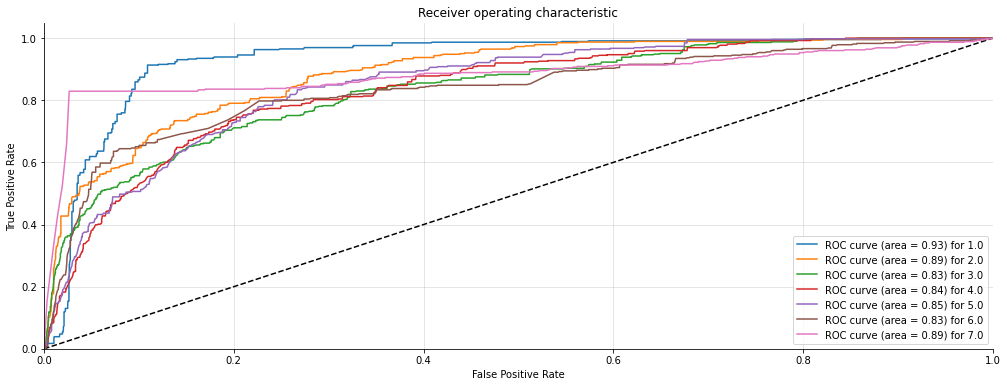

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.49      0.93      0.64       461
         2.0       0.68      0.52      0.59       488
         3.0       0.62      0.48      0.54       506
         4.0       0.56      0.41      0.48       516
         5.0       0.53      0.43      0.47       456
         6.0       0.59      0.63      0.61       471
         7.0       0.79      0.79      0.79       462

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.59      3360

Confusion Matrix: 
 [[430  12  10   0   0   5   4]
 [115 252  58  24  14  23   2]
 [110  32 241  84  14  22   3]
 [ 86  29  35 214 115  33   4]
 [ 82  14  16  36 195 113   0]
 [ 32  17  14   6  20 296  86]
 [ 31  15  16  18   9   6 367]]
Accuracy Score : 0.59375
Precision Score : 0.6080500371562069
Recall Score : 0.59375
F1 Score : 0.5857273085368979
(3360, 7) (3360, 7

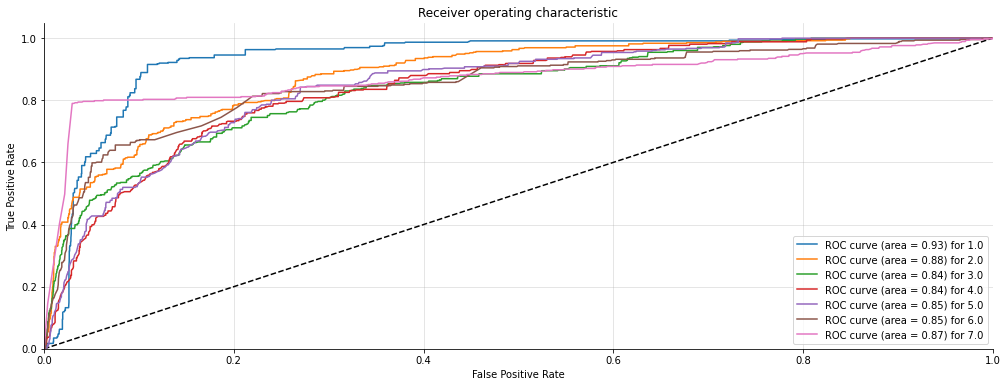

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.49      0.90      0.64       463
         2.0       0.71      0.55      0.62       491
         3.0       0.71      0.50      0.59       487
         4.0       0.72      0.60      0.65       518
         5.0       0.83      0.61      0.70       487
         6.0       0.74      0.87      0.80       462
         7.0       0.96      0.99      0.97       452

    accuracy                           0.71      3360
   macro avg       0.74      0.72      0.71      3360
weighted avg       0.74      0.71      0.71      3360

Confusion Matrix: 
 [[418  12  10   0   0  19   4]
 [117 268  47  29   7  23   0]
 [111  33 243  66  15  19   0]
 [ 84  35  17 309  33  31   9]
 [ 92  15  17  24 295  44   0]
 [ 30  14   6   2   3 402   5]
 [  0   0   1   1   1   3 446]]
Accuracy Score : 0.7086309523809524
Precision Score : 0.7375605426124182
Recall Score : 0.7086309523809524
F1 Score : 0.70621100407454

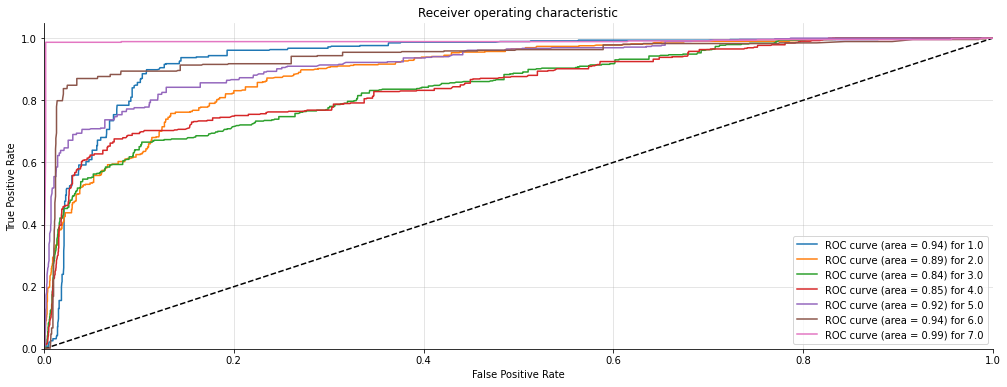

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.48      0.90      0.62       461
         2.0       0.70      0.51      0.59       495
         3.0       0.69      0.48      0.57       490
         4.0       0.70      0.56      0.62       519
         5.0       0.81      0.60      0.69       481
         6.0       0.74      0.87      0.80       465
         7.0       0.97      0.99      0.98       449

    accuracy                           0.69      3360
   macro avg       0.72      0.70      0.70      3360
weighted avg       0.72      0.69      0.69      3360

Confusion Matrix: 
 [[415  12   8   0   2  20   4]
 [124 252  52  31   8  28   0]
 [119  38 237  63  14  19   0]
 [ 88  39  25 290  40  31   6]
 [ 92   8  16  30 291  44   0]
 [ 30  13   6   2   6 403   5]
 [  0   0   1   1   0   1 446]]
Accuracy Score : 0.6946428571428571
Precision Score : 0.7225817298124296
Recall Score : 0.6946428571428571
F1 Score : 0.69

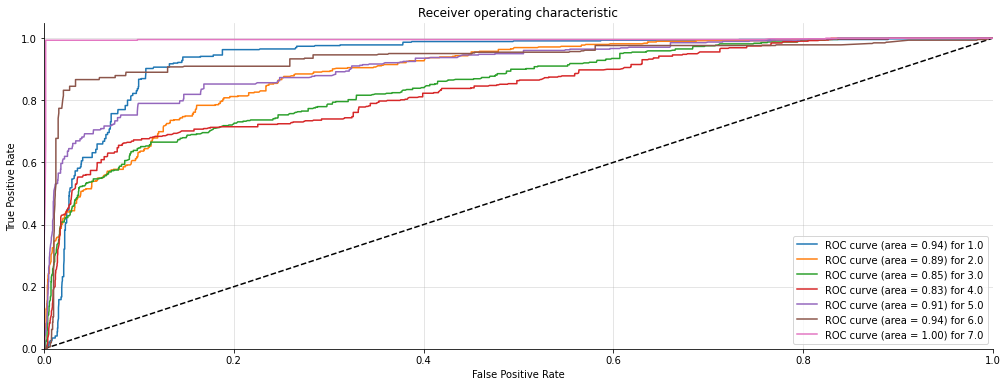

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.50      0.92      0.65       460
         2.0       0.74      0.56      0.64       502
         3.0       0.79      0.62      0.70       474
         4.0       0.81      0.61      0.70       527
         5.0       0.85      0.64      0.73       486
         6.0       0.76      0.90      0.82       459
         7.0       0.98      1.00      0.99       452

    accuracy                           0.74      3360
   macro avg       0.78      0.75      0.75      3360
weighted avg       0.78      0.74      0.74      3360

Confusion Matrix: 
 [[424   3   8   0   2  19   4]
 [129 283  28  23  14  24   1]
 [ 91  33 295  23  15  17   0]
 [ 74  38  30 321  24  35   5]
 [ 92  13   8  27 312  34   0]
 [ 31  11   4   0   2 411   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.7431547619047619
Precision Score : 0.7770400479353354
Recall Score : 0.7431547619047619
F1 Score : 0.7433602

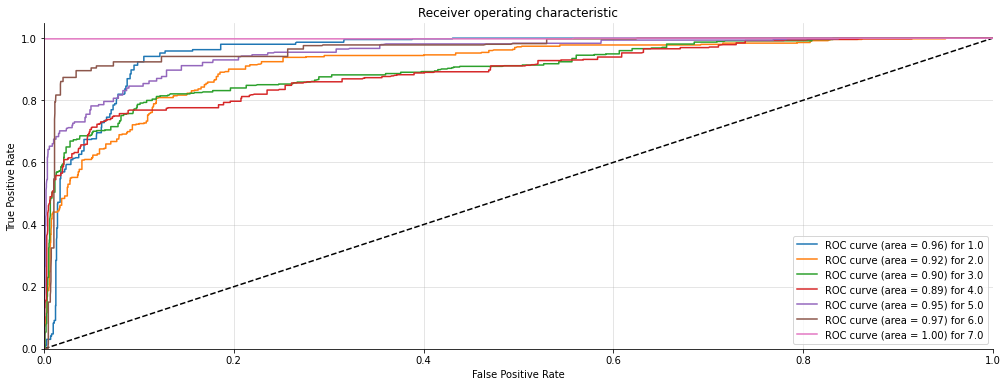

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.51      0.93      0.66       459
         2.0       0.77      0.62      0.68       496
         3.0       0.85      0.64      0.73       478
         4.0       0.87      0.66      0.75       523
         5.0       0.88      0.65      0.75       491
         6.0       0.77      0.90      0.83       462
         7.0       0.98      1.00      0.99       451

    accuracy                           0.77      3360
   macro avg       0.80      0.77      0.77      3360
weighted avg       0.81      0.77      0.77      3360

Confusion Matrix: 
 [[425   0   8   0   2  19   5]
 [123 306  20  15   8  24   0]
 [ 98  28 308  16  15  13   0]
 [ 68  42  15 346  17  30   5]
 [ 92  13   8  20 320  38   0]
 [ 29  11   4   0   0 418   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.7660714285714286
Precision Score : 0.805358561315085
Recall Score : 0.7660714285714286
F1 Score : 0.768731580193

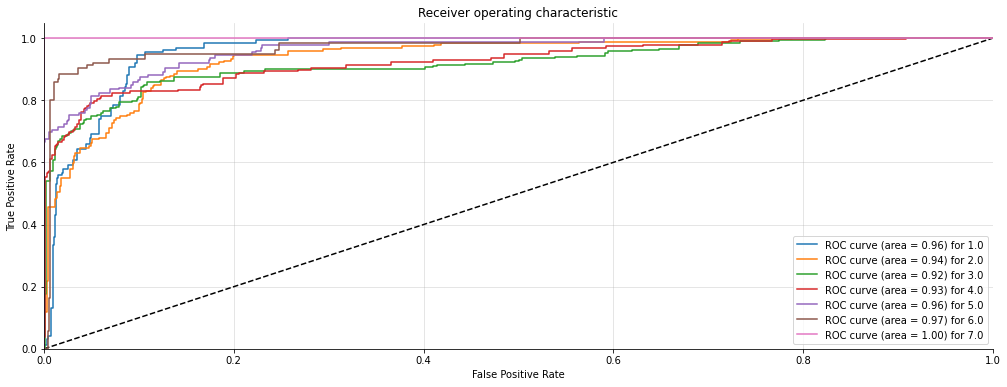

In [38]:
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def SVMmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    svc = SVC( probability=True)
    svc.fit(X_train, y_train)

    # predictions over test set
    predictions=[round(float(x)) for x in svc.predict(X_test)]
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(svc, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  SVMmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [39]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average auc score {}".format(np.mean(aucscore)))
metric_df['SVM'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.6644717261904762
average Precision :0.6875574125764237
average Recall :0.6644717261904762
average F1 -score :0.6599242897764944
average RMSE -score :1.4349871844855193
average auc score 0.8045293087029316


## 3.7. Custom-Built Ordinal Classifier

Credit: [Muhammad for Towards Data Science](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)

Ordinal classifier basically does a similar thing to one-hot encoding -- but despite having one value each column, ordinal encoding maps unique binary values for each of our unique classes.

We implement a custom object called `OrdinalClassifier` built on top of any `sklearn` model that supports the `predict_proba()` function; ranging from Naive Bayes to decision trees.

Last implementation, we deduced the labels by one, from `[1,2,3,4,5,6,7]` to `[0,1,2,3,4,5,6]` due to the nature of zero-indexing of standard sklearn library. But this doesn't work if the labels aren't ranging fully from 1 to 7 -- could be 2 to 6 or 2 to 7 instead.

So the solution is to change the overall behavior of the `OrdinalClassifier` object to take maximum class (e.g. 7) and minimum class (e.g. 2 or 3) into consideration. From there, we simulate the `np.argmax()` function to be added the minimum class before being returned. We also add the minimum class as an index towards `self.clfs` dictionary when adding new value, so we don't need to deduce the labels by hand. In other words, labels stay as-is instead of being deduced by 1 :)

This also changes how the approach for ordinal encoding works -- instead of `k - 1` like the author's original implementation, we feed `k` numbers of encoding because our labels are already one-indexed.

Keep in mind that the `predict_proba()` function does not yet implement this change, because it's only a wrapper function before eventually calling `predict()` in which we care the most about the result. 

For column: obstructive<==>supportive
[01:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:48] WARNING: C:/Users/Adm

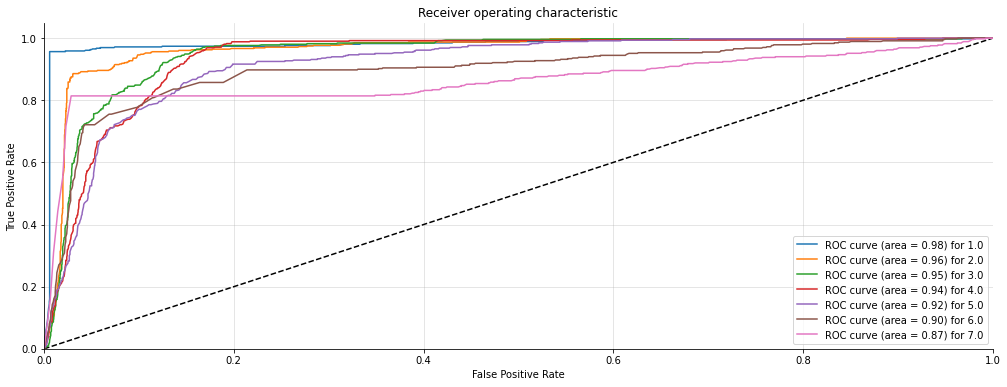

For column: complicated<==>easy
[01:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:52] WARNING: C:/Users/Administr

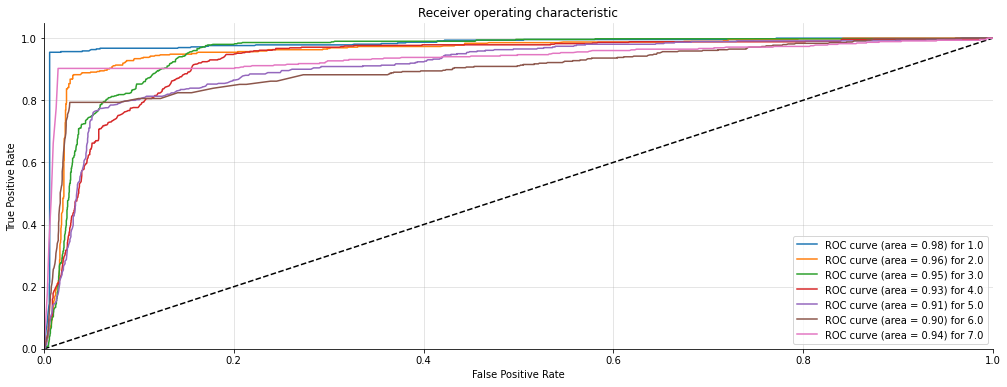

For column: inefficient<==>efficient
[01:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:56] WARNING: C:/Users/Admi

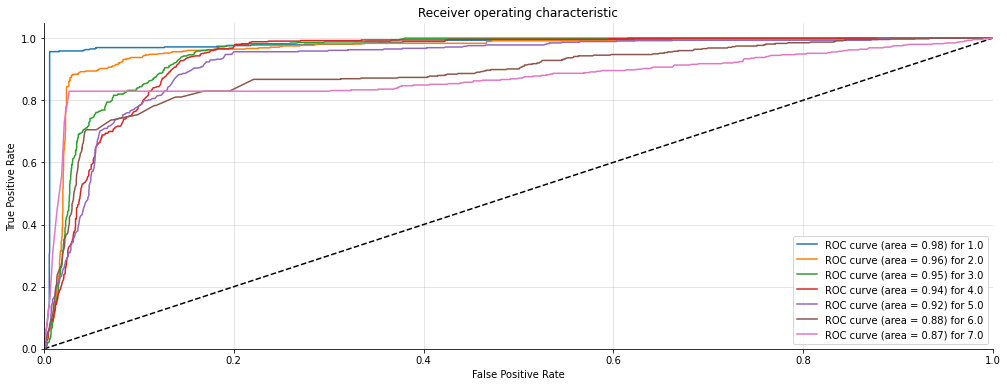

For column:  confusing<==>clear
[01:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:00] WARNING: C:/Users/Administr

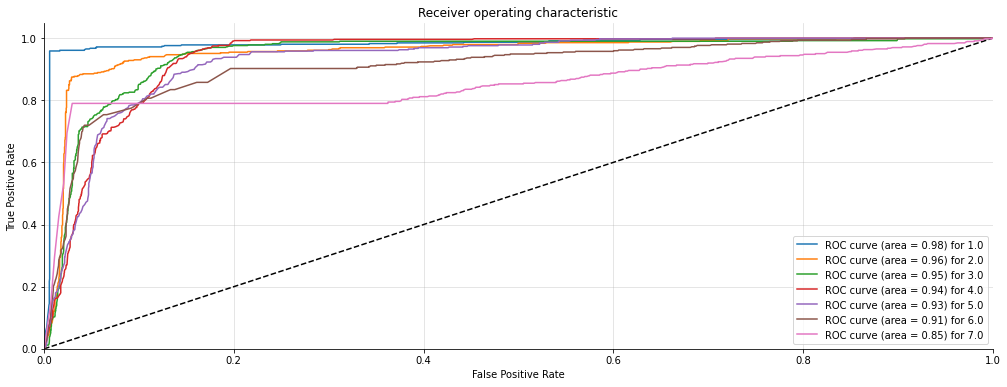

For column: boring<==>exciting
[01:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:04] WARNING: C:/Users/Administra

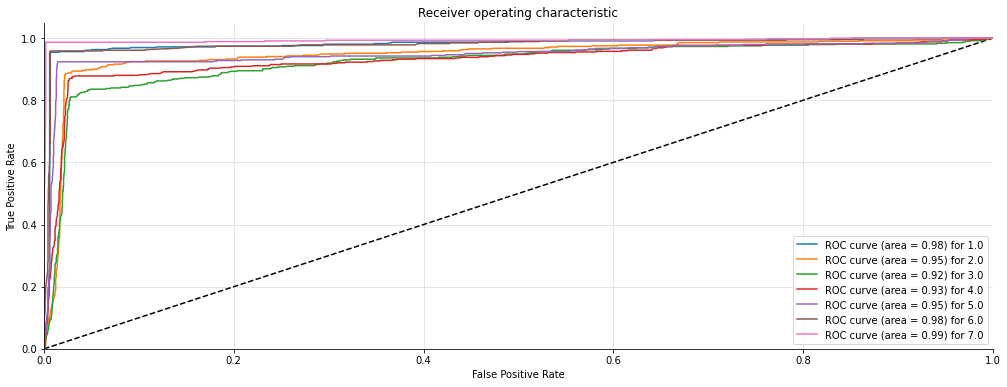

For column: not interesting<==>interesting
[01:33:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:09] WARNING: C:/User

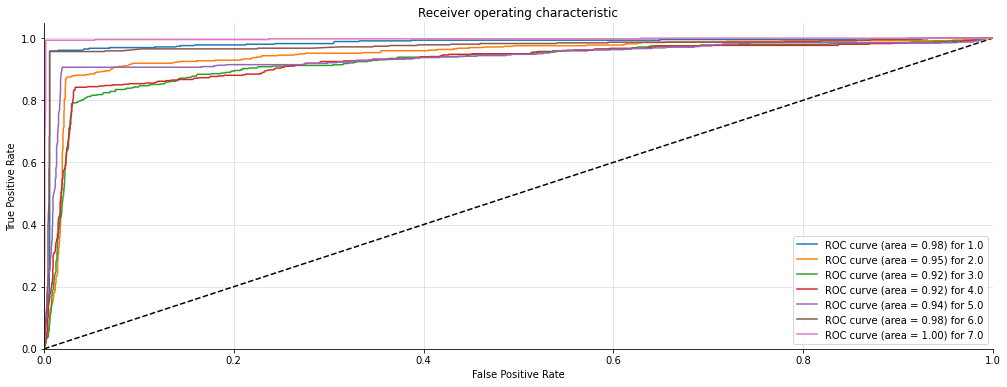

For column: conventional<==>inventive
[01:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:12] WARNING: C:/Users/Adm

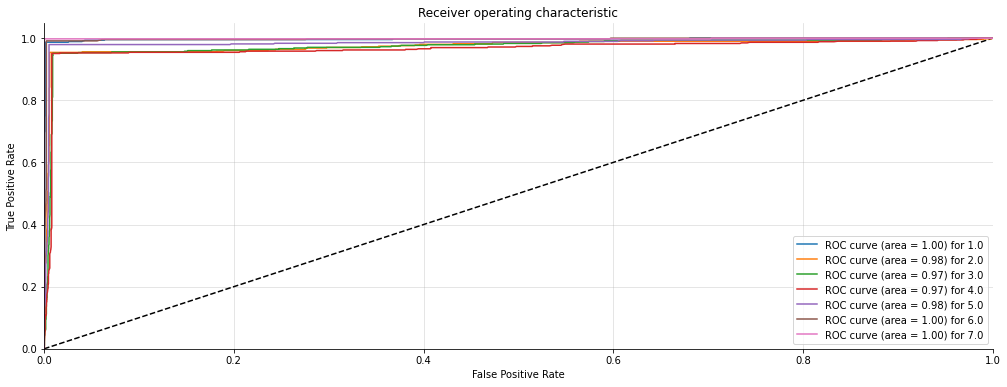

For column: usual<==>leading edge
[01:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:33:15] WARNING: C:/Users/Adminis

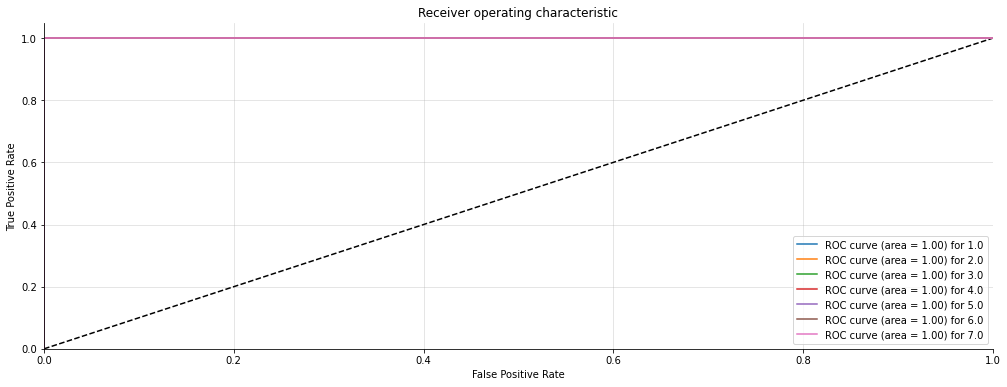

In [40]:
from sklearn.base import clone

acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        self.max_class = max(self.unique_class)
        self.min_class = min(self.unique_class)
        if self.unique_class.shape[0] > 2:
            # print(self.unique_class.shape[0]) # Uncomment to debug
            for i in range(self.unique_class.shape[0]):
                # for each k ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                
                
                clf.fit(X, binary_y)
                self.clfs[i + self.min_class] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        # print(self.clfs) # Uncomment to debug
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + self.min_class

def OrdinalModel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    clf = OrdinalClassifier(XGBClassifier()) # Using XGB as the placeholder model 
    clf.fit(X_train, y_train)

    # predictions over test set
    predictions = clf.predict(X_test)
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    aucscore.append(score_auc(y_test,predictions))

    plot_multiclass_roc(clf, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  OrdinalModel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))
  #break # Uncomment to debug

In [41]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC score:{}".format(np.mean(aucscore)))
metric_df['OrdinalModel'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.863467261904762
average Precision :0.8633704150578027
average Recall :0.863467261904762
average F1 -score :0.8632973755407436
average RMSE -score :0.6057908739825265
average AUC score:0.9201703517426675


# 4. Other Deep Learning Model(s)

## 4.1. Bidirectional LSTM

In [42]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=[rmse])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 520       
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 5s 125ms/step - loss: 17.4591 - rmse: 3.6765 - val_loss: 6.9541 - val_rmse: 2.4360
Epoch 2/100
21/21 [==============================] - 2s 91ms/step - loss: 6.2406 - rmse: 2.2965 - val_loss: 4.1835 - val_rmse: 1.7886
Epoch 3/100
21/21 [==============================] - 2s 80ms/step - loss: 5.1606 - rmse: 2.0487 - val_loss: 4.0663 - val_rmse: 1.7588
Epoch 4/100
21/21 [==============================] - 2s 80ms/step - loss: 4.8780 - rmse: 1.9819 - val_loss: 3.8341 - val_rmse: 1.7025
Epoch 5/100
21/21 [==============================] - 2s 90ms/step - loss: 4.2857 - rmse: 1.8461 - val_loss: 2.7323 - val_rmse: 1.4154
Epoch 6/100
21/21 [==============================] - 2s 78ms/step - loss: 2.5816 - rmse: 1.3867 - val_loss: 1.2853 - val_rmse: 0.8445
Epoch 7/100
21/21 [==============================] - 2s 79ms/step - loss: 1.8058 - rmse: 1.1313 - val_loss: 1.0394 - val_rmse: 0.7257
Epoch 8/100
21/21 [==============================] - 2s 88ms

21/21 [==============================] - 2s 85ms/step - loss: 0.7359 - rmse: 0.6032 - val_loss: 0.5229 - val_rmse: 0.4074
Epoch 62/100
21/21 [==============================] - 2s 90ms/step - loss: 0.7350 - rmse: 0.5997 - val_loss: 0.5280 - val_rmse: 0.4294
Epoch 63/100
21/21 [==============================] - 2s 83ms/step - loss: 0.7306 - rmse: 0.6011 - val_loss: 0.5584 - val_rmse: 0.4560
Epoch 64/100
21/21 [==============================] - 2s 88ms/step - loss: 0.7384 - rmse: 0.6017 - val_loss: 0.5293 - val_rmse: 0.4269
Epoch 65/100
21/21 [==============================] - 2s 90ms/step - loss: 0.7190 - rmse: 0.5918 - val_loss: 0.5215 - val_rmse: 0.4043
Epoch 66/100
21/21 [==============================] - 2s 101ms/step - loss: 0.7292 - rmse: 0.5946 - val_loss: 0.5245 - val_rmse: 0.4157
Epoch 67/100
21/21 [==============================] - 2s 91ms/step - loss: 0.7336 - rmse: 0.5985 - val_loss: 0.5195 - val_rmse: 0.4075
Epoch 68/100
21/21 [==============================] - 2s 80ms/step 

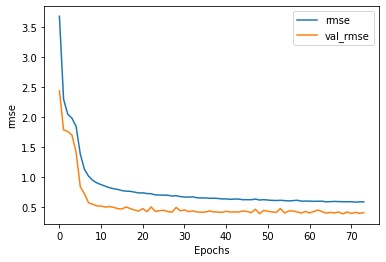

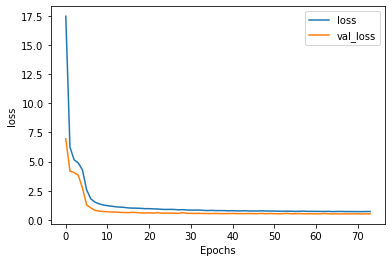

In [44]:
plot_graphs(history, "rmse")
plot_graphs(history, "loss")

In [45]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 9s 3ms/step - loss: 0.5399 - rmse: 0.4168
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 53.99%
rmse: 41.68%


In [46]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]

In [47]:
from sklearn.metrics import classification_report, f1_score
y_pred = LSTM_model.predict(X_test)
for i in range(8):
    print("Column", df.columns[1:][i])
    estimates = [round(float(x)) for x in y_pred[:,i]]
    estimates = transform_results(estimates)
    print(np.unique(estimates))
    acc.append(accuracy_score(y_test[:,i], estimates))
    pre.append(precision_score(y_test[:,i], estimates,average='weighted'))
    recal.append(recall_score(y_test[:,i], estimates,average='weighted'))
    f1.append(f1_score(y_test[:,i], estimates,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:,i], estimates)))
    aucscore.append(score_auc(y_test[:,i], estimates))
    print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[0 1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.96      0.92      0.94       462
         2.0       0.80      0.76      0.78       482
         3.0       0.68      0.69      0.68       510
         4.0       0.65      0.70      0.67       517
         5.0       0.63      0.67      0.65       467
         6.0       0.73      0.69      0.71       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.75      3360
   macro avg       0.66      0.66      0.66      3360
weighted avg       0.75      0.75      0.75      3360
 
------
Column complicated<==>easy
[0 1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.96      0.94      0.95       463
         2.0       0.83      0.78      0.80       485
         3.0       0.68     

In [48]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['Bidirectional LSTM'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8366815476190477
average Precision :0.8393434429683836
average Recall :0.8366815476190477
average F1 -score :0.8376696765075302
average RMSE -score :0.6568727826999682
average AUC -score :0.9045136018506296


In [49]:
metric_df

metric  Neural network classifier       XGB       SVM  OrdinalModel  \
0   Accuracy                   0.743118  0.863653  0.664472      0.863467   
1  Precision                   0.759766  0.863599  0.687557      0.863370   
2     Recall                   0.743118  0.863653  0.664472      0.863467   
3   F1 Score                   0.742916  0.863497  0.659924      0.863297   
4       RMSE                   0.758905  0.615966  1.434987      0.605791   
5  AUC score                   0.849650  0.920289  0.804529      0.920170   

   Bidirectional LSTM  
0            0.836682  
1            0.839343  
2            0.836682  
3            0.837670  
4            0.656873  
5            0.904514

# Result

In [50]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.96      0.95      0.96      3691
         2.0       0.85      0.80      0.83      3921
         3.0       0.74      0.75      0.75      3952
         4.0       0.76      0.80      0.78      4161
         5.0       0.79      0.82      0.80      3786
         6.0       0.87      0.84      0.86      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.84     26880
   macro avg       0.74      0.73      0.74     26880
weighted avg       0.84      0.84      0.84     26880



## 4.2. BERT [deprecated]

In [51]:
"""!pip install -q -U tensorflow-text
!pip install -q tf-models-official
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

to_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
to_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model = hub.KerasLayer(to_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_model(text_test)

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {to_handle}')
history = classifier_model.fit(X_train, y_train)"""

"!pip install -q -U tensorflow-text\n!pip install -q tf-models-official\nimport tensorflow_hub as hub\nimport tensorflow_text as text\nfrom official.nlp import optimization  # to create AdamW optimizer\n\nto_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'\nto_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'\nbert_model = hub.KerasLayer(to_preprocess)\n\ntext_test = ['this is such an amazing movie!']\ntext_preprocessed = bert_model(text_test)\n\ndef build_classifier_model():\n  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')\n  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')\n  encoder_inputs = preprocessing_layer(text_input)\n  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(1, activation=None, name='classifi

# 4.3 RBFN

In [52]:

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

In [53]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        print("done")
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [54]:
import numpy as np, pandas as pd
from keras.models import Sequential 
from keras.layers.core import Dense
from keras.layers import Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [55]:
model = Sequential()
rbflayer = RBFLayer(100,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=(X_train.shape[1],))
model.add(rbflayer)
model.add(Dense(8))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['accuracy'])
model.build(X_train.shape)
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (13440, 100)              2100      
_________________________________________________________________
dense (Dense)                (13440, 8)                808       
_________________________________________________________________
activation (Activation)      (13440, 8)                0         
Total params: 2,908
Trainable params: 2,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
420/420 [==============================] - 17s 2ms/step - loss: 19.4613 - accuracy: 0.5533
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 16.0085 - accuracy: 0.1201
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 13.5771 - accuracy: 0.4190
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - los

420/420 [==============================] - 1s 2ms/step - loss: 3.7586 - accuracy: 0.3670
Epoch 68/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7566 - accuracy: 0.1150
Epoch 69/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7600 - accuracy: 0.7018
Epoch 70/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7025 - accuracy: 0.7613
Epoch 71/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7510 - accuracy: 0.4745
Epoch 72/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7326 - accuracy: 0.4476
Epoch 73/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7235 - accuracy: 0.6498
Epoch 74/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7649 - accuracy: 0.7244
Epoch 75/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7896 - accuracy: 0.0875
Epoch 76/100
420/420 [==============================] - 1s 2ms/step - loss: 3.7698 - accuracy: 

In [56]:
y_train.shape

(13440, 8)

In [57]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 4s 1ms/step - loss: 3.6227 - accuracy: 0.7738
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 362.27%
accuracy: 77.38%


In [58]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]

In [59]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
    print("Column", df.columns[1:][i])
    estimates = [round(float(x)) for x in y_pred[:,i]]
    estimates = transform_results(estimates)
    print(np.unique(estimates))
    acc.append(accuracy_score(y_test[:,i], estimates))
    pre.append(precision_score(y_test[:,i], estimates,average='weighted'))
    recal.append(recall_score(y_test[:,i], estimates,average='weighted'))
    f1.append(f1_score(y_test[:,i], estimates,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:,i], estimates)))
    aucscore.append(score_auc(y_test[:,i], estimates))
    print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 4 5 6 7]
              precision    recall  f1-score   support

         1.0       1.00      0.01      0.01       462
         2.0       0.00      0.00      0.00       482
         3.0       0.00      0.00      0.00       510
         4.0       0.16      0.98      0.27       517
         5.0       0.64      0.04      0.08       467
         6.0       0.76      0.06      0.11       470
         7.0       0.82      0.13      0.23       452

    accuracy                           0.18      3360
   macro avg       0.48      0.18      0.10      3360
weighted avg       0.47      0.18      0.10      3360
 
------
Column complicated<==>easy
[1 4 5 6 7]
              precision    recall  f1-score   support

         1.0       1.00      0.01      0.01       463
         2.0       0.00      0.00      0.00       485
         3.0       0.00      0.00      0.00       501
         4.0       0.16      0.98      0.27       515
         5.0       0.62      0.03      0

In [60]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['RBFN'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.1916294642857143
average Precision :0.5215693367664324
average Recall :0.1916294642857143
average F1 -score :0.11168477053799197
average RMSE -score :1.907201864823914
average AUC -score :0.5218464823656046


In [61]:
LSTM_y_pred = model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [[2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [4. 4. 4. 4. 5. 5. 5. 5.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [7. 7. 7. 7. 2. 2. 1. 1.]]
Predicted labels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       1.00      0.01      0.01      3691
         2.0       0.00      0.00      0.00      3921
         3.0       0.00      0.00      0.00      3952
         4.0       0.16      0.99      0.28      4161
         5.0       0.79      0.05      0.10      3786
         6.0       0.89      0.07      0.13      3748
         7.0       0.92      0.15      0.26      3621

    accuracy                           0.19     26880
   macro avg       0.54      0.18      0.11     26880
weighted avg       0.52      0.19      0.11     268

In [62]:
from sklearn.metrics import classification_report

In [63]:
X_test.shape

(3360, 20)

In [64]:
y_test.shape

(3360, 8)

In [65]:
metric_df

metric  Neural network classifier       XGB       SVM  OrdinalModel  \
0   Accuracy                   0.743118  0.863653  0.664472      0.863467   
1  Precision                   0.759766  0.863599  0.687557      0.863370   
2     Recall                   0.743118  0.863653  0.664472      0.863467   
3   F1 Score                   0.742916  0.863497  0.659924      0.863297   
4       RMSE                   0.758905  0.615966  1.434987      0.605791   
5  AUC score                   0.849650  0.920289  0.804529      0.920170   

   Bidirectional LSTM      RBFN  
0            0.836682  0.191629  
1            0.839343  0.521569  
2            0.836682  0.191629  
3            0.837670  0.111685  
4            0.656873  1.907202  
5            0.904514  0.521846

# 4.4 Multiclass Logistic regression

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.21      0.53      0.30       462
         2.0       0.24      0.16      0.19       482
         3.0       0.20      0.05      0.07       510
         4.0       0.25      0.15      0.19       517
         5.0       0.26      0.16      0.20       467
         6.0       0.18      0.14      0.16       470
         7.0       0.49      0.84      0.62       452

    accuracy                           0.28      3360
   macro avg       0.26      0.29      0.25      3360
weighted avg       0.26      0.28      0.24      3360

Confusion Matrix: 
 [[244  36  15  30  21  60  56]
 [182  75  16  45  34  70  60]
 [182  73  23  59  50  69  54]
 [186  52  27  79  61  46  66]
 [202  41  13  55  75  40  41]
 [151  30  17  38  44  65 125]
 [ 30   9   6   7   7  13 380]]
Accuracy Score : 0.2800595238095238
Precision Score : 0.25734226688836465
Recall Score : 0.2800595238095238
F1 Score : 0.240479

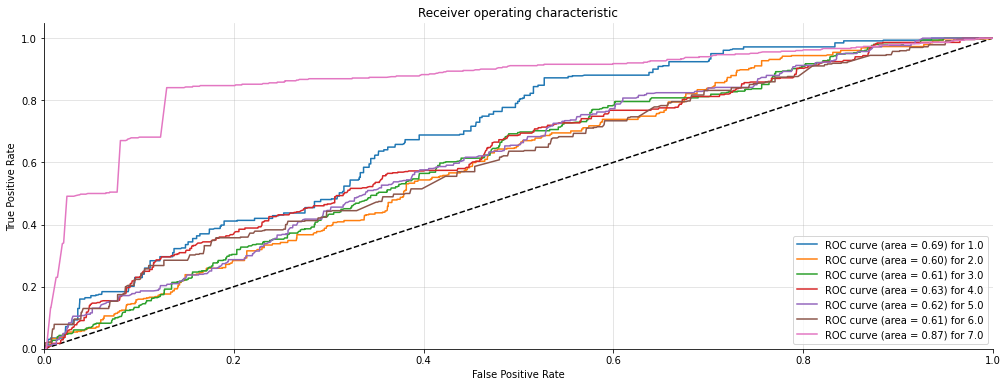

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.28      0.27      0.27       463
         2.0       0.23      0.16      0.19       485
         3.0       0.25      0.11      0.15       501
         4.0       0.20      0.20      0.20       515
         5.0       0.25      0.23      0.24       460
         6.0       0.26      0.34      0.29       484
         7.0       0.52      0.92      0.67       452

    accuracy                           0.31      3360
   macro avg       0.28      0.32      0.29      3360
weighted avg       0.28      0.31      0.28      3360

Confusion Matrix: 
 [[123  43  33  57  64  79  64]
 [ 65  79  45  89  50  98  59]
 [ 68  77  53  83  65 102  53]
 [ 74  67  37 101  81  90  65]
 [ 53  44  24 101 104 100  34]
 [ 55  38  20  55  49 166 101]
 [  8   3   3  13   3   8 414]]
Accuracy Score : 0.30952380952380953
Precision Score : 0.28018195299685056
Recall Score : 0.30952380952380953
F1 Score : 0.2818049012

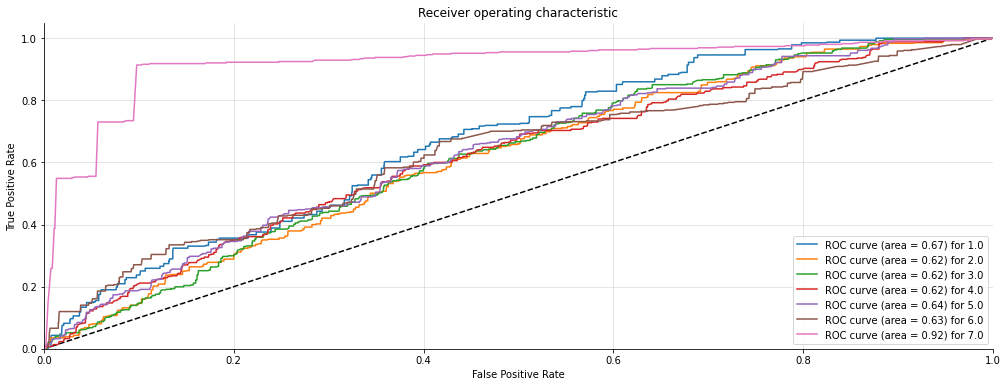

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.21      0.53      0.30       462
         2.0       0.23      0.15      0.18       482
         3.0       0.21      0.06      0.09       506
         4.0       0.25      0.15      0.19       526
         5.0       0.29      0.16      0.20       458
         6.0       0.21      0.17      0.19       475
         7.0       0.48      0.85      0.61       451

    accuracy                           0.29      3360
   macro avg       0.27      0.29      0.25      3360
weighted avg       0.27      0.29      0.25      3360

Confusion Matrix: 
 [[245  36  15  29  18  55  64]
 [179  71  23  45  27  73  64]
 [180  63  28  64  43  76  52]
 [188  52  29  80  53  52  72]
 [193  41  12  58  73  42  39]
 [147  36  18  36  36  81 121]
 [ 31   7   7   9   6   9 382]]
Accuracy Score : 0.2857142857142857
Precision Score : 0.26616962534569305
Recall Score : 0.2857142857142857
F1 Score : 0.2468813

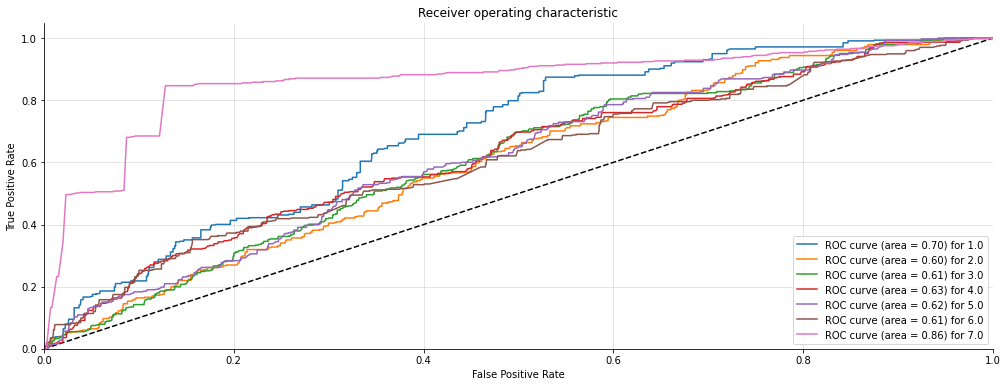

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.21      0.52      0.30       461
         2.0       0.24      0.14      0.17       488
         3.0       0.22      0.05      0.08       506
         4.0       0.21      0.14      0.17       516
         5.0       0.27      0.18      0.22       456
         6.0       0.24      0.20      0.21       471
         7.0       0.47      0.81      0.60       462

    accuracy                           0.28      3360
   macro avg       0.27      0.29      0.25      3360
weighted avg       0.26      0.28      0.25      3360

Confusion Matrix: 
 [[242  31  15  29  21  59  64]
 [183  66  17  58  38  64  62]
 [180  70  25  62  46  70  53]
 [185  50  28  71  66  47  69]
 [187  28  13  57  81  46  44]
 [136  24  10  48  38  92 123]
 [ 38  11   6  15   7  11 374]]
Accuracy Score : 0.2830357142857143
Precision Score : 0.2635195614096063
Recall Score : 0.2830357142857143
F1 Score : 0.2451813873058

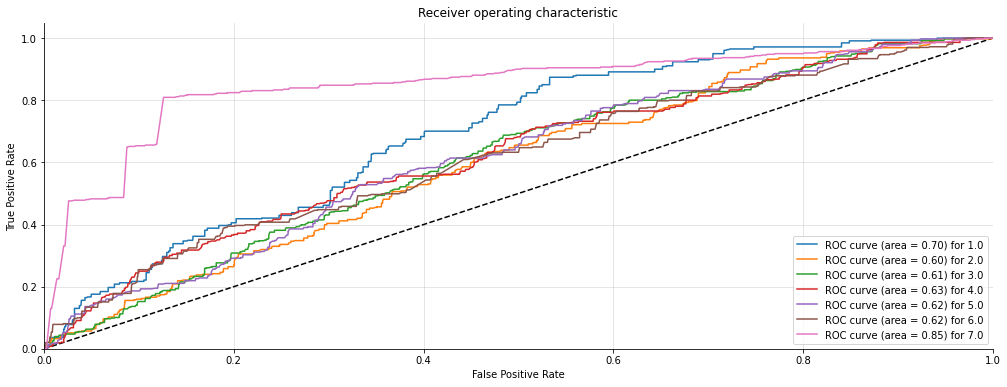

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.26      0.21      0.23       463
         2.0       0.21      0.14      0.17       491
         3.0       0.22      0.12      0.16       487
         4.0       0.18      0.14      0.16       518
         5.0       0.25      0.30      0.28       487
         6.0       0.30      0.46      0.36       462
         7.0       0.67      0.99      0.80       452

    accuracy                           0.33      3360
   macro avg       0.30      0.34      0.31      3360
weighted avg       0.29      0.33      0.30      3360

Confusion Matrix: 
 [[ 98  48  45  52  78  87  55]
 [ 60  71  43  73  93 112  39]
 [ 51  60  60  67 104 115  30]
 [ 62  68  50  74 113 116  35]
 [ 49  54  46  88 147  79  24]
 [ 53  34  33  47  47 214  34]
 [  2   1   0   1   0   1 447]]
Accuracy Score : 0.3306547619047619
Precision Score : 0.2944753589864921
Recall Score : 0.3306547619047619
F1 Score : 0.30213345898222

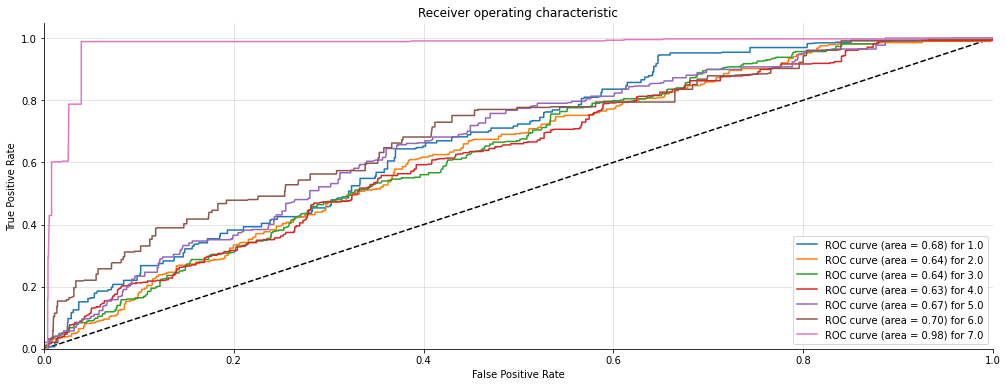

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.26      0.22      0.24       461
         2.0       0.24      0.14      0.17       495
         3.0       0.20      0.11      0.14       490
         4.0       0.22      0.20      0.21       519
         5.0       0.25      0.29      0.27       481
         6.0       0.28      0.43      0.34       465
         7.0       0.67      1.00      0.80       449

    accuracy                           0.33      3360
   macro avg       0.30      0.34      0.31      3360
weighted avg       0.30      0.33      0.30      3360

Confusion Matrix: 
 [[100  48  28  52  85  94  54]
 [ 60  67  42  88  88 110  40]
 [ 59  49  52  86 102 111  31]
 [ 65  48  48 103 106 113  36]
 [ 48  43  50  91 139  87  23]
 [ 53  29  39  56  47 200  41]
 [  1   0   0   0   0   1 447]]
Accuracy Score : 0.32976190476190476
Precision Score : 0.29564338552568487
Recall Score : 0.32976190476190476
F1 Score : 0

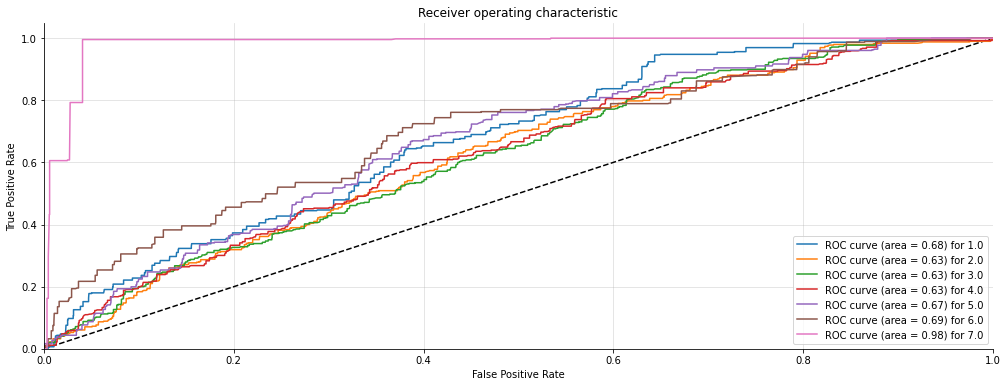

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.30      0.23      0.26       460
         2.0       0.22      0.14      0.17       502
         3.0       0.21      0.13      0.16       474
         4.0       0.20      0.16      0.18       527
         5.0       0.25      0.30      0.28       486
         6.0       0.29      0.46      0.35       459
         7.0       0.70      1.00      0.82       452

    accuracy                           0.34      3360
   macro avg       0.31      0.35      0.32      3360
weighted avg       0.30      0.34      0.31      3360

Confusion Matrix: 
 [[107  51  55  43  70  83  51]
 [ 63  71  49  86  84 108  41]
 [ 38  51  63  68  99 128  27]
 [ 60  61  49  83 125 120  29]
 [ 41  50  44 102 148  80  21]
 [ 50  43  35  30  62 211  28]
 [  0   0   0   1   0   0 451]]
Accuracy Score : 0.3375
Precision Score : 0.30441081833578887
Recall Score : 0.3375
F1 Score : 0.31083518293709894
(3360, 7) (3

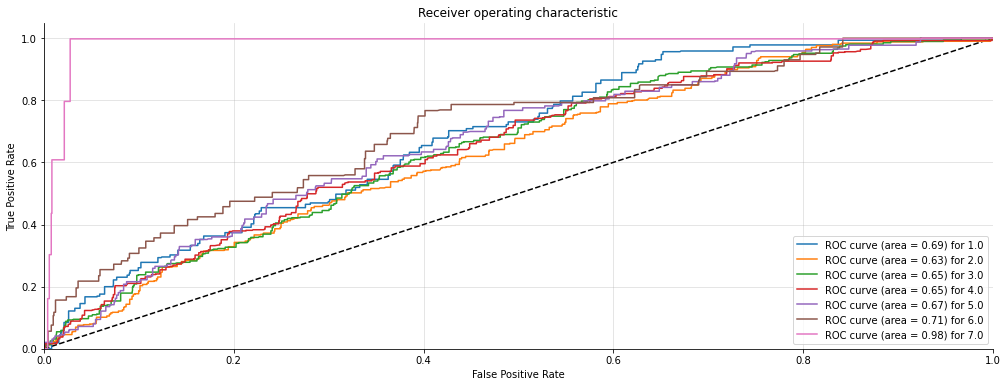

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.31      0.23      0.26       459
         2.0       0.23      0.16      0.19       496
         3.0       0.21      0.15      0.17       478
         4.0       0.23      0.17      0.20       523
         5.0       0.25      0.31      0.28       491
         6.0       0.30      0.45      0.36       462
         7.0       0.71      1.00      0.83       451

    accuracy                           0.34      3360
   macro avg       0.32      0.35      0.33      3360
weighted avg       0.31      0.34      0.32      3360

Confusion Matrix: 
 [[106  59  52  47  69  79  47]
 [ 55  81  58  78  80 105  39]
 [ 39  55  70  60 108 120  26]
 [ 56  58  57  91 131 105  25]
 [ 39  57  44  96 152  82  21]
 [ 51  42  46  23  63 208  29]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.3449404761904762
Precision Score : 0.31476851028837105
Recall Score : 0.3449404761904762
F1 Score : 0.3208296047

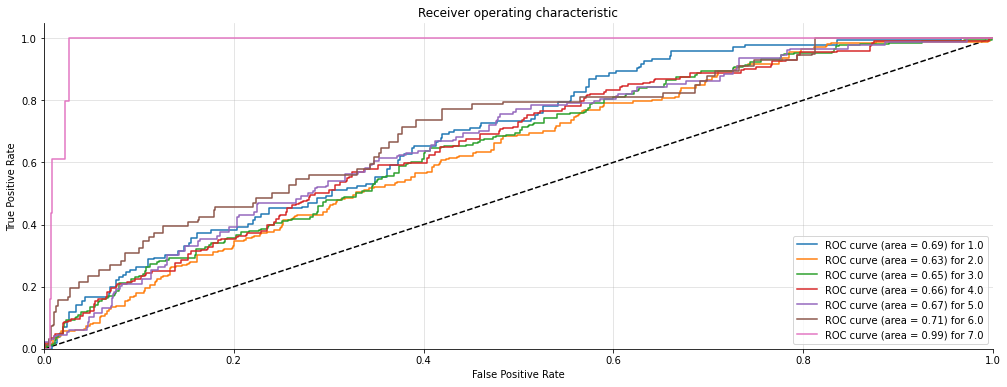

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def Logistic(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  Logistic(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [67]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE :{}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['LogisticModel'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.3126488095238095
average Precision :0.2845639349721064
average Recall :0.3126488095238095
average F1 -score :0.2811914806001804
average RMSE :2.4321152435050224
average AUC score 0.5994629538208693


# 4.5 Neural network - classifier

In [68]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[rmse], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

Epoch 1/150
588/588 - 3s - loss: 4.8260 - rmse: 1.8234 - val_loss: 2.8964 - val_rmse: 1.3358
Epoch 2/150
588/588 - 3s - loss: 2.6805 - rmse: 1.3514 - val_loss: 1.9030 - val_rmse: 1.0741
Epoch 3/150
588/588 - 2s - loss: 1.9759 - rmse: 1.1632 - val_loss: 1.3753 - val_rmse: 0.9143
Epoch 4/150
588/588 - 2s - loss: 1.6269 - rmse: 1.0447 - val_loss: 1.5855 - val_rmse: 1.0301
Epoch 5/150
588/588 - 3s - loss: 1.4231 - rmse: 0.9721 - val_loss: 1.1698 - val_rmse: 0.8583
Epoch 6/150
588/588 - 3s - loss: 1.2543 - rmse: 0.9037 - val_loss: 1.1031 - val_rmse: 0.8129
Epoch 7/150
588/588 - 3s - loss: 1.2191 - rmse: 0.8784 - val_loss: 1.0092 - val_rmse: 0.7781
Epoch 8/150
588/588 - 2s - loss: 1.1308 - rmse: 0.8396 - val_loss: 0.9589 - val_rmse: 0.7543
Epoch 9/150
588/588 - 2s - loss: 1.0739 - rmse: 0.8070 - val_loss: 0.8357 - val_rmse: 0.6676
Epoch 10/150
588/588 - 2s - loss: 1.0085 - rmse: 0.7768 - val_loss: 0.7630 - val_rmse: 0.6543
Epoch 11/150
588/588 - 2s - loss: 0.9557 - rmse: 0.7437 - val_loss: 0

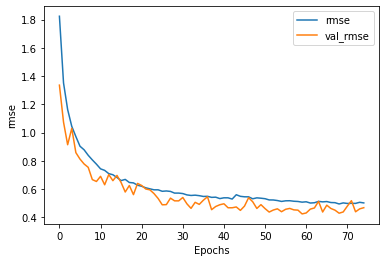

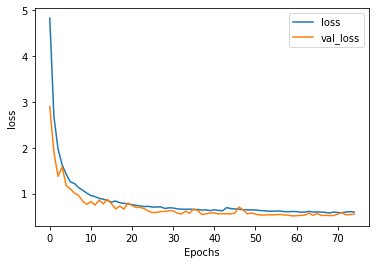

In [69]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "rmse")
plot_graphs(history, "loss")

In [70]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 5s 1ms/step - loss: 0.5699 - rmse: 0.4707
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 56.99%
rmse: 47.07%


In [71]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]

In [72]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
    print("Column", df.columns[1:][i])
    estimates = [round(float(x)) for x in y_pred[:,i]]
    estimates = transform_results(estimates)
    print(np.unique(estimates))
    acc.append(accuracy_score(y_test[:,i], estimates))
    pre.append(precision_score(y_test[:,i], estimates,average='weighted'))
    recal.append(recall_score(y_test[:,i], estimates,average='weighted'))
    f1.append(f1_score(y_test[:,i], estimates,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:,i], estimates)))
    aucscore.append(score_auc(y_test[:,i], estimates))
    print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.96      0.92      0.94       462
         2.0       0.76      0.54      0.63       482
         3.0       0.52      0.67      0.59       510
         4.0       0.61      0.65      0.63       517
         5.0       0.59      0.64      0.61       467
         6.0       0.66      0.65      0.65       470
         7.0       0.82      0.71      0.76       452

    accuracy                           0.68      3360
   macro avg       0.70      0.68      0.69      3360
weighted avg       0.70      0.68      0.69      3360
 
------
Column complicated<==>easy
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.96      0.92      0.94       463
         2.0       0.77      0.57      0.66       485
         3.0       0.54      0.69      0.61       501
         4.0       0.64      0.66      0.65       515
         5.0       0.66      0.7

In [73]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['Neural Network classifier 2'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.7814360119047619
average Precision :0.7923829395401658
average Recall :0.7814360119047619
average F1 -score :0.7835323978319253
average RMSE -score :0.7217734826141756
average AUC -score :0.872090559970055


# 4.6 LSTM 

In [74]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
     
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=[rmse])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 520       
Total params: 792,136
Trainable params: 792,136
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 9s 334ms/step - loss: 14.1523 - rmse: 3.2978 - val_loss: 4.4831 - val_rmse: 1.8629
Epoch 2/100
21/21 [==============================] - 6s 288ms/step - loss: 5.4986 - rmse: 2.1089 - val_loss: 4.1397 - val_rmse: 1.7459
Epoch 3/100
21/21 [==============================] - 6s 288ms/step - loss: 5.0103 - rmse: 2.0026 - val_loss: 4.0090 - val_rmse: 1.7155
Epoch 4/100
21/21 [==============================] - 6s 270ms/step - loss: 4.6745 - rmse: 1.9261 - val_loss: 3.7551 - val_rmse: 1.6559
Epoch 5/100
21/21 [==============================] - 6s 286ms/step - loss: 4.0520 - rmse: 1.7720 - val_loss: 2.6391 - val_rmse: 1.3334
Epoch 6/100
21/21 [==============================] - 6s 303ms/step - loss: 2.3845 - rmse: 1.3010 - val_loss: 1.3195 - val_rmse: 0.8310
Epoch 7/100
21/21 [==============================] - 6s 264ms/step - loss: 1.6425 - rmse: 1.0399 - val_loss: 0.9864 - val_rmse: 0.6571
Epoch 8/100
21/21 [==============================] - 6

21/21 [==============================] - 5s 225ms/step - loss: 0.6271 - rmse: 0.5386 - val_loss: 0.5194 - val_rmse: 0.4120
Epoch 62/100
21/21 [==============================] - 5s 243ms/step - loss: 0.6257 - rmse: 0.5402 - val_loss: 0.5211 - val_rmse: 0.3989
Epoch 63/100
21/21 [==============================] - 5s 226ms/step - loss: 0.6240 - rmse: 0.5383 - val_loss: 0.5154 - val_rmse: 0.3961
Epoch 64/100
21/21 [==============================] - 5s 222ms/step - loss: 0.6242 - rmse: 0.5373 - val_loss: 0.5435 - val_rmse: 0.4438
Epoch 65/100
21/21 [==============================] - 5s 225ms/step - loss: 0.6262 - rmse: 0.5423 - val_loss: 0.5220 - val_rmse: 0.4183
Epoch 66/100
21/21 [==============================] - 5s 225ms/step - loss: 0.6165 - rmse: 0.5372 - val_loss: 0.5171 - val_rmse: 0.4118
Epoch 67/100
21/21 [==============================] - 5s 225ms/step - loss: 0.6179 - rmse: 0.5338 - val_loss: 0.5201 - val_rmse: 0.3986
Epoch 68/100
21/21 [==============================] - 5s 242m

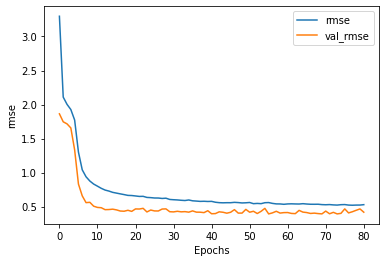

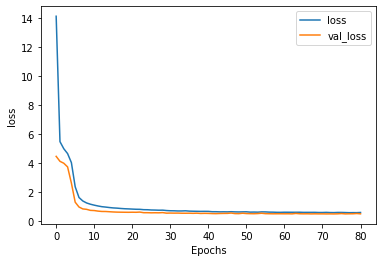

In [76]:
plot_graphs(history, "rmse")
plot_graphs(history, "loss")

In [77]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 7s 2ms/step - loss: 0.5313 - rmse: 0.4183
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 53.13%
rmse: 41.83%


In [78]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]

In [79]:
from sklearn.metrics import classification_report, f1_score
y_pred = LSTM_model.predict(X_test)
for i in range(8):
    print("Column", df.columns[1:][i])
    estimates = [round(float(x)) for x in y_pred[:,i]]
    estimates = transform_results(estimates)
    print(np.unique(estimates))
    acc.append(accuracy_score(y_test[:,i], estimates))
    pre.append(precision_score(y_test[:,i], estimates,average='weighted'))
    recal.append(recall_score(y_test[:,i], estimates,average='weighted'))
    f1.append(f1_score(y_test[:,i], estimates,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:,i], estimates)))
    aucscore.append(score_auc(y_test[:,i], estimates))
    print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.96      0.89      0.92       462
         2.0       0.78      0.74      0.76       482
         3.0       0.66      0.70      0.68       510
         4.0       0.64      0.69      0.66       517
         5.0       0.62      0.64      0.63       467
         6.0       0.74      0.71      0.72       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.74      3360
   macro avg       0.75      0.74      0.74      3360
weighted avg       0.74      0.74      0.74      3360
 
------
Column complicated<==>easy
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.96      0.89      0.92       463
         2.0       0.78      0.74      0.76       485
         3.0       0.66      0.71      0.69       501
         4.0       0.65      0.71      0.68       515
         5.0       0.68      0.6

In [80]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['Bidirectional LSTM 2'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8352306547619048
average Precision :0.8379495060678943
average Recall :0.8352306547619048
average F1 -score :0.8361746931885421
average RMSE -score :0.6547310448476876
average AUC -score :0.9035777770305772


# 4.7 Ensemble

In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 4.7.1 Decison tree classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.82      0.88      0.85       482
         3.0       0.76      0.72      0.74       510
         4.0       0.67      0.68      0.68       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  4 424  51   1   0   2   0]
 [  0  20 365 117   2   3   3]
 [  0   1  21 350 144   1   0]
 [  4   6  13  30 302 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  26  21  11  10   6 368]]
Accuracy Score : 0.7708333333333334
Precision Score : 0.770018380266448
Recall Score : 0.7708333333333334
F1 Score : 0.77016560

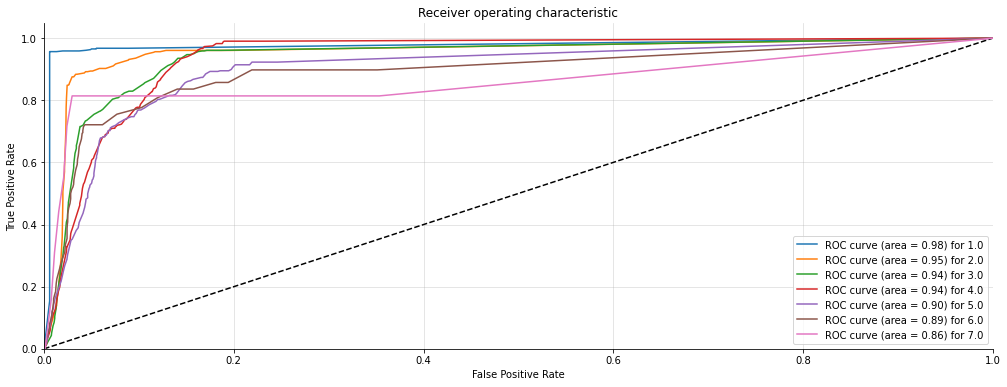

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.83      0.88      0.85       485
         3.0       0.75      0.72      0.73       501
         4.0       0.68      0.69      0.69       515
         5.0       0.70      0.72      0.71       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  4 425  51   0   1   4   0]
 [  0  18 360 119   4   0   0]
 [  0   3  31 354 125   2   0]
 [  3  13  16  28 330  70   0]
 [  5  17  16  13   6 384  43]
 [  9  19   5   4   5   2 408]]
Accuracy Score : 0.8044642857142857
Precision Score : 0.804565913322212
Recall Score : 0.8044642857142857
F1 Score : 0.80427728111189

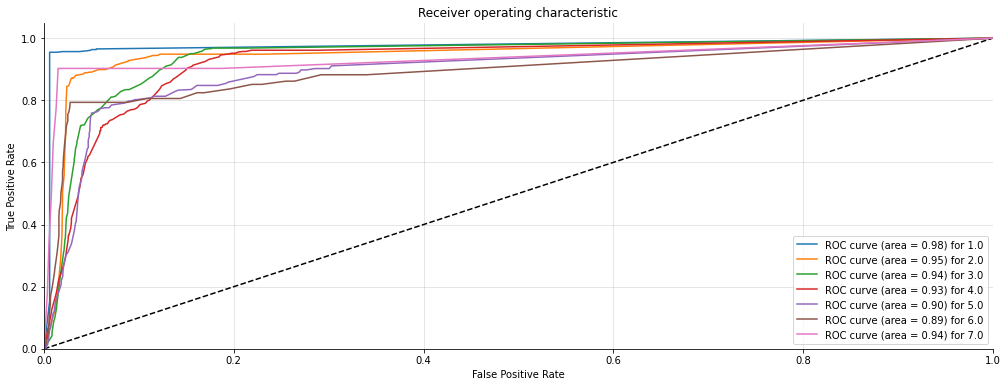

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.83      0.88      0.85       482
         3.0       0.75      0.72      0.73       506
         4.0       0.68      0.67      0.67       526
         5.0       0.66      0.66      0.66       458
         6.0       0.72      0.71      0.71       475
         7.0       0.82      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  4 425  51   1   0   1   0]
 [  0  18 362 119   1   3   3]
 [  0   3  29 350 144   0   0]
 [  2   5   6  24 304 117   0]
 [  6  17  22  11   7 335  77]
 [  9  28  14  12   8   6 374]]
Accuracy Score : 0.7714285714285715
Precision Score : 0.7704285240244723
Recall Score : 0.7714285714285715
F1 Score : 0.77071046

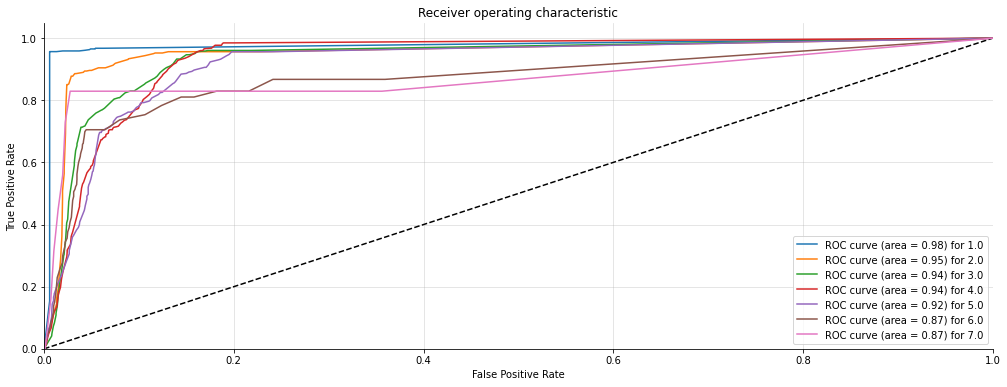

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       461
         2.0       0.83      0.87      0.85       488
         3.0       0.75      0.71      0.73       506
         4.0       0.67      0.67      0.67       516
         5.0       0.66      0.67      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.80      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  4 425  52   2   2   3   0]
 [  0  19 361 122   0   1   3]
 [  0   1  24 344 145   2   0]
 [  2   2   8  24 307 113   0]
 [  2  14  18   8   4 339  86]
 [ 13  35  21  15   9   4 365]]
Accuracy Score : 0.76875
Precision Score : 0.7683602863694446
Recall Score : 0.76875
F1 Score : 0.768380249634554
(3360, 7) (3360, 7)

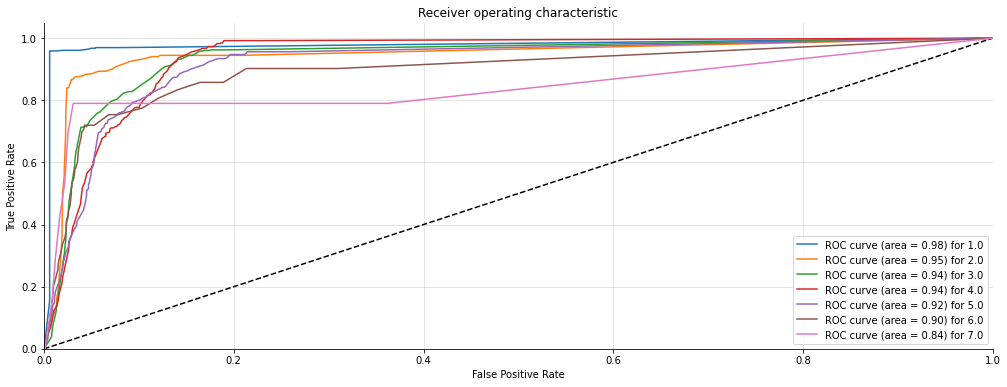

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.89      0.88       491
         3.0       0.83      0.80      0.82       487
         4.0       0.86      0.87      0.86       518
         5.0       0.92      0.92      0.92       487
         6.0       0.95      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 435  44   3   1   3   0]
 [  7  27 390  58   2   3   0]
 [  3  15  17 451  31   1   0]
 [  1   5  11  13 446  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9086309523809524
Precision Score : 0.9085680334842574
Recall Score : 0.9086309523809524
F1 Score : 0.90852487367335

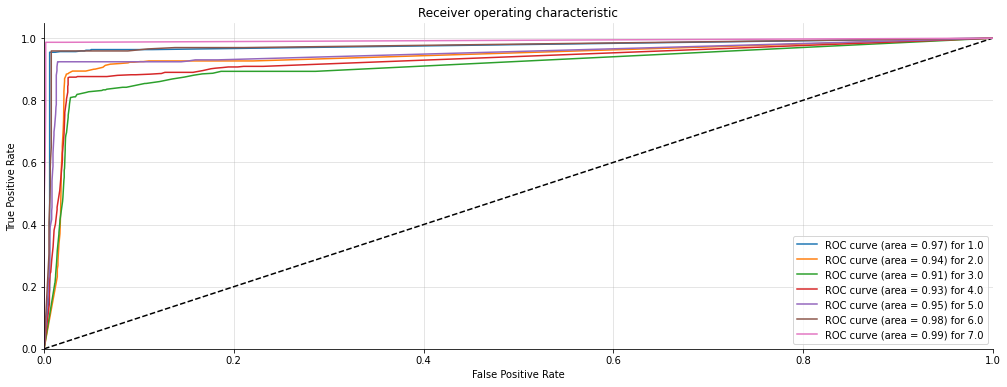

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.87       495
         3.0       0.82      0.78      0.80       490
         4.0       0.82      0.84      0.83       519
         5.0       0.89      0.90      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 432  49   3   2   4   0]
 [  7  26 384  69   0   4   0]
 [  3  17  17 436  46   0   0]
 [  1   7  11  19 432  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8979166666666667
Precision Score : 0.8977050792040955
Recall Score : 0.8979166666666667
F1 Score : 0.89

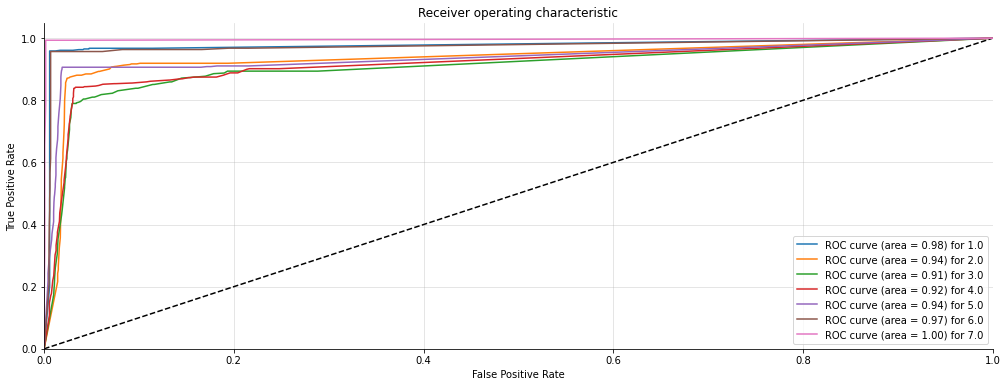

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.94       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  6 478  15   2   1   0   0]
 [  0  13 448  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9708333333333333
Precision Score : 0.9708090759968673
Recall Score : 0.9708333333333333
F1 Score : 0.9708113

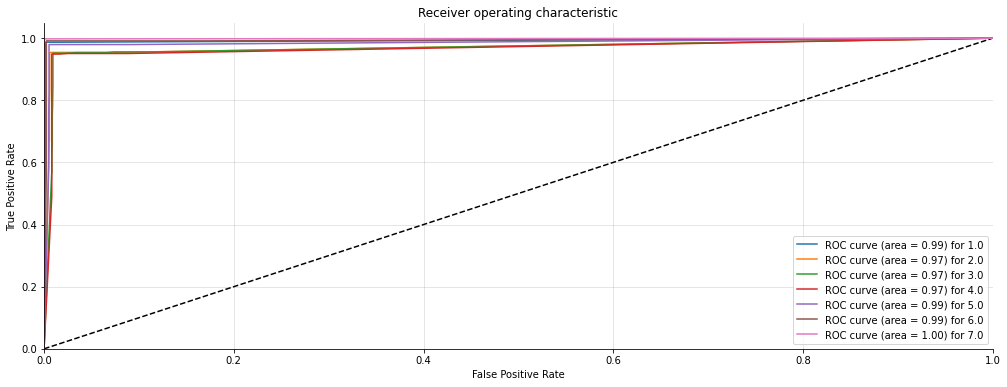

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


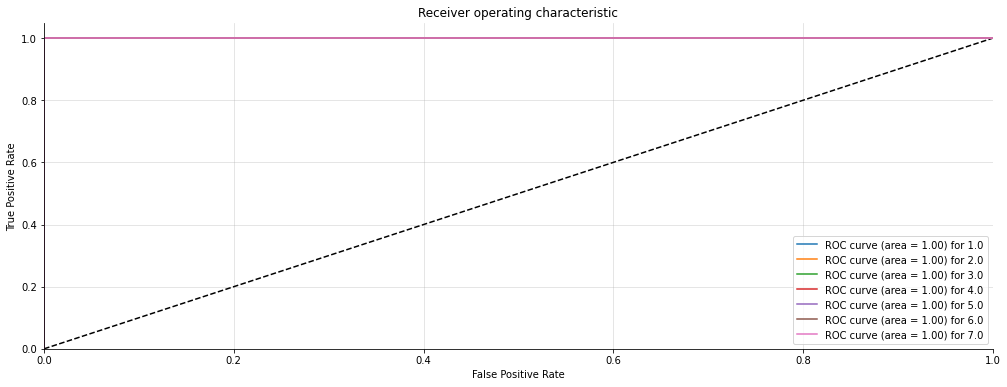

In [82]:
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def DTC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    aucscore.append(score_auc(y_test,predictions))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))


    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  DTC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [83]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE :{}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['DecisionTreeclasssifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8616071428571428
average Precision :0.8613069115834746
average Recall :0.8616071428571428
average F1 -score :0.8613245352824729
average RMSE :0.6038498676558416
average AUC score 0.919074296026043


# 4.7.2 Random forest classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.77      0.72      0.74       510
         4.0       0.67      0.68      0.68       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.80      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  3 424  51   1   0   2   1]
 [  0  10 367 122   2   3   6]
 [  0   1  16 354 145   1   0]
 [  4   5  14  29 303 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  26  21  11  10   6 368]]
Accuracy Score : 0.7729166666666667
Precision Score : 0.772528458940461
Recall Score : 0.7729166666666667
F1 Score : 0.77251131

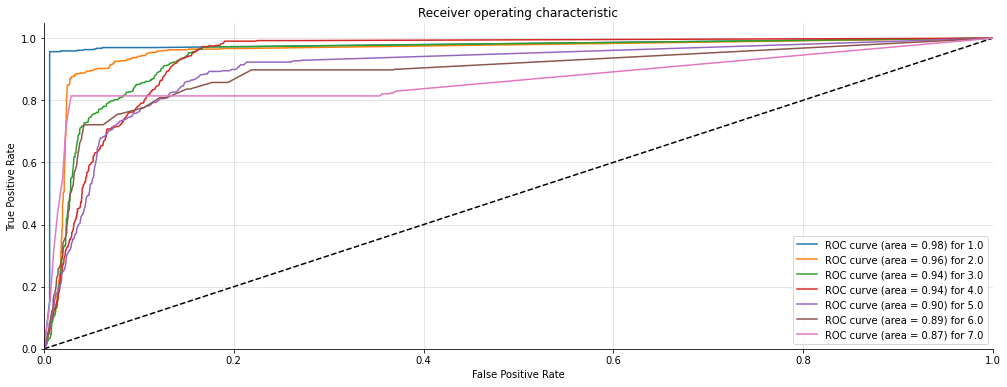

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.76      0.72      0.74       501
         4.0       0.69      0.70      0.69       515
         5.0       0.71      0.73      0.72       460
         6.0       0.82      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 425  51   1   1   4   0]
 [  0  11 363 120   4   3   0]
 [  0   3  27 358 125   2   0]
 [  3  13  16  21 337  70   0]
 [  5  17  16  13   6 384  43]
 [  9  19   5   4   5   2 408]]
Accuracy Score : 0.8086309523809524
Precision Score : 0.8088818738052779
Recall Score : 0.8086309523809524
F1 Score : 0.8085502641908

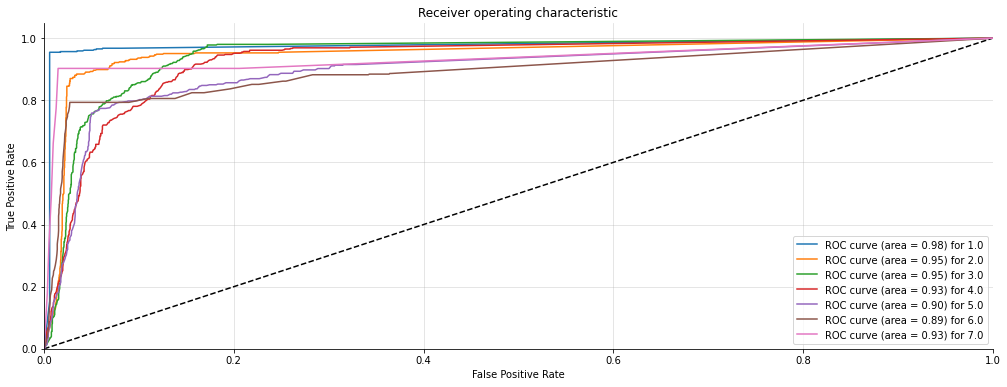

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.76      0.72      0.74       506
         4.0       0.68      0.67      0.68       526
         5.0       0.65      0.67      0.66       458
         6.0       0.72      0.71      0.71       475
         7.0       0.82      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  3 425  51   1   0   1   1]
 [  0   9 366 121   1   6   3]
 [  0   3  24 354 145   0   0]
 [  2   5   6  23 305 117   0]
 [  6  17  22  11   7 335  77]
 [  9  28  14  12   8   6 374]]
Accuracy Score : 0.7741071428571429
Precision Score : 0.7734908053069706
Recall Score : 0.7741071428571429
F1 Score : 0.77364613

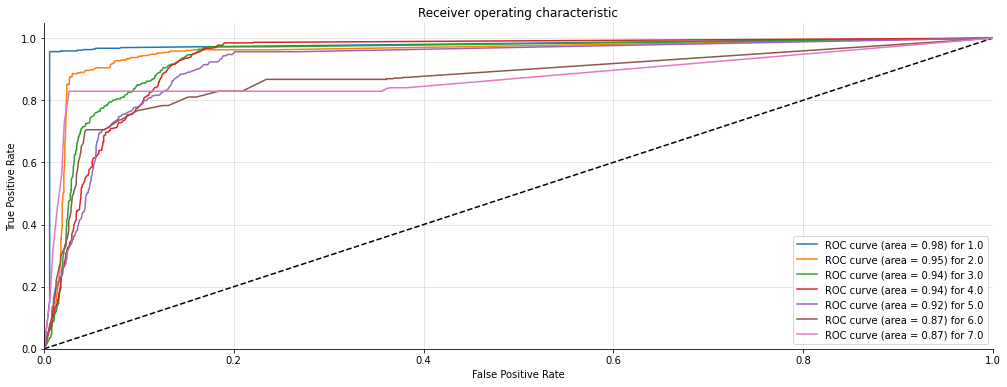

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.87      0.86       488
         3.0       0.75      0.72      0.74       506
         4.0       0.67      0.67      0.67       516
         5.0       0.66      0.68      0.67       456
         6.0       0.73      0.72      0.72       471
         7.0       0.80      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 425  52   2   2   3   1]
 [  0  10 364 125   0   4   3]
 [  0   1  20 347 146   2   0]
 [  2   2   8  21 310 113   0]
 [  2  14  18   8   4 339  86]
 [ 13  35  21  15   9   4 365]]
Accuracy Score : 0.7714285714285715
Precision Score : 0.7714390609108809
Recall Score : 0.7714285714285715
F1 Score : 0.7712982265858

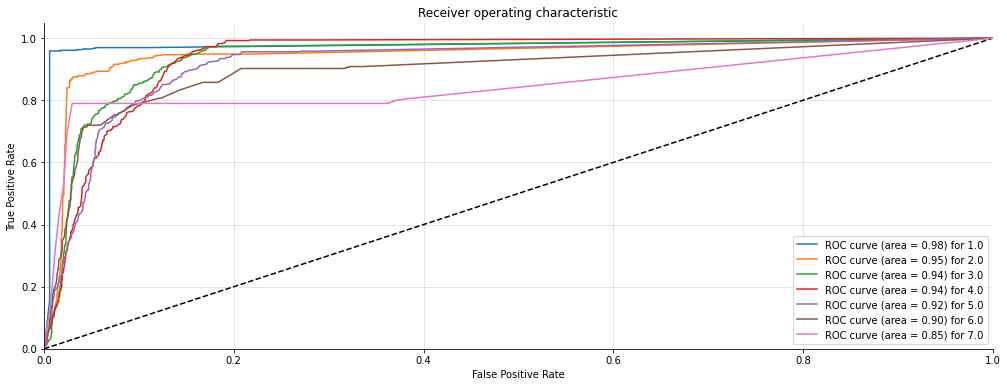

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.83      0.81      0.82       487
         4.0       0.86      0.87      0.86       518
         5.0       0.92      0.92      0.92       487
         6.0       0.95      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 434  45   3   1   3   0]
 [  7  23 394  58   2   3   0]
 [  3  15  17 451  31   1   0]
 [  1   5  11  13 446  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9095238095238095
Precision Score : 0.9094951829209865
Recall Score : 0.9095238095238095
F1 Score : 0.90946728077385

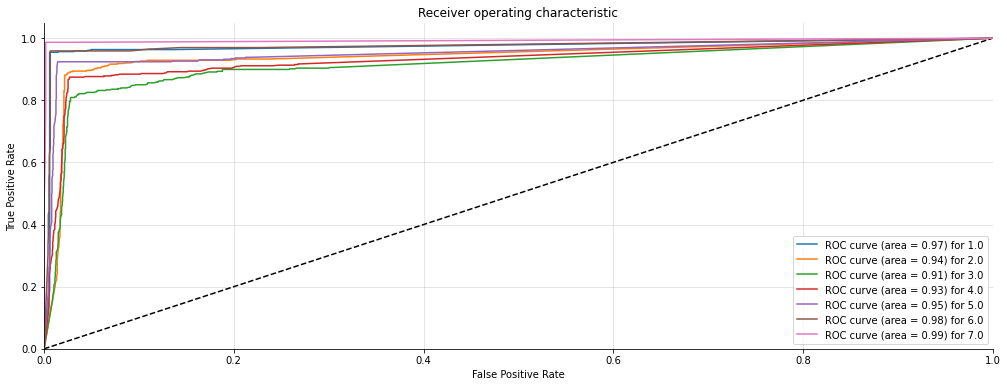

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.87      0.87      0.87       495
         3.0       0.82      0.79      0.80       490
         4.0       0.82      0.84      0.83       519
         5.0       0.89      0.90      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 431  50   3   2   4   0]
 [  7  23 387  69   0   4   0]
 [  3  17  17 436  46   0   0]
 [  1   7  11  19 432  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8985119047619048
Precision Score : 0.8983404099675748
Recall Score : 0.8985119047619048
F1 Score : 0.89

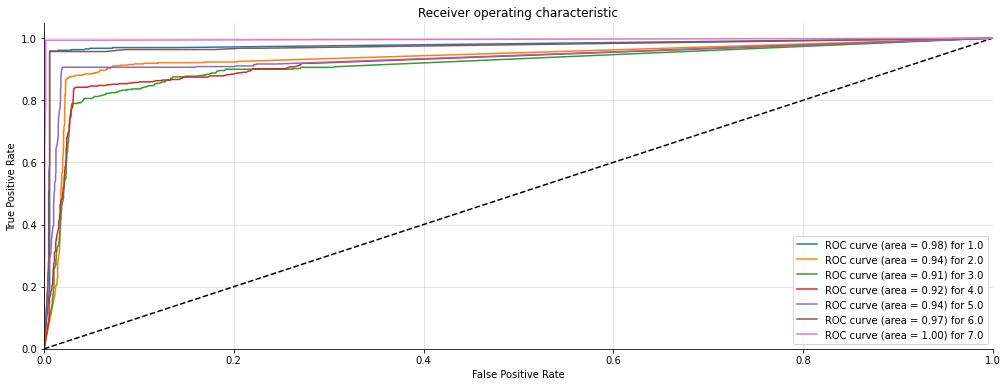

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.94       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  13 448  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9711309523809524
Precision Score : 0.9711154774382756
Recall Score : 0.9711309523809524
F1 Score : 0.9711141

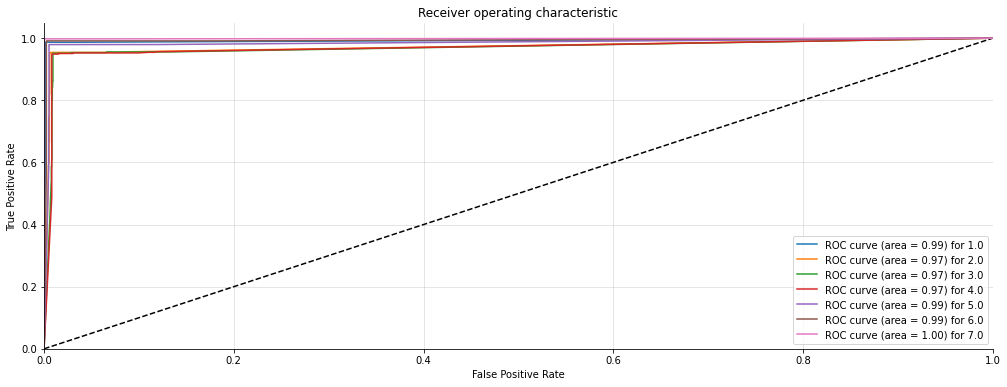

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


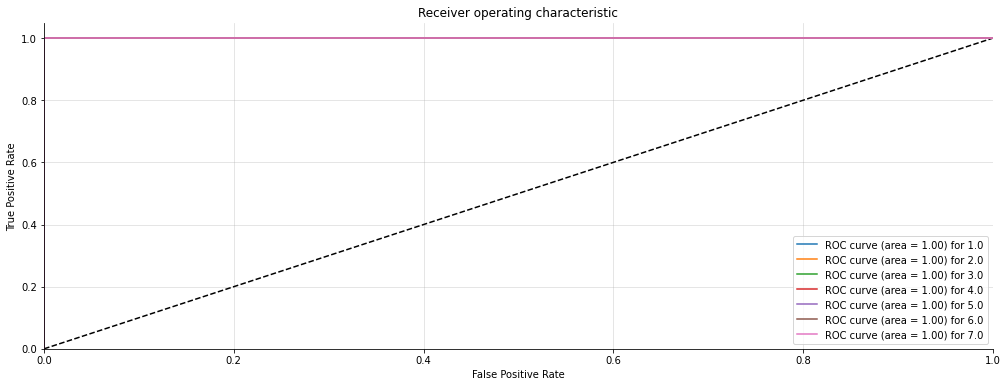

In [84]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def RFC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  RFC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [85]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['RandomForestClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.86328125
average Precision :0.8631614086613034
average Recall :0.86328125
average F1 -score :0.8631193613243041
average RMSE 0.6065019394805715
average AUC score 0.9200568617466774


# 4.7.3 Extra Trees Classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.82      0.88      0.85       482
         3.0       0.76      0.72      0.74       510
         4.0       0.67      0.68      0.68       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  4 424  51   1   0   2   0]
 [  0  20 365 117   2   3   3]
 [  0   1  21 350 144   1   0]
 [  4   6  13  30 302 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  26  21  11  10   6 368]]
Accuracy Score : 0.7708333333333334
Precision Score : 0.770018380266448
Recall Score : 0.7708333333333334
F1 Score : 0.77016560

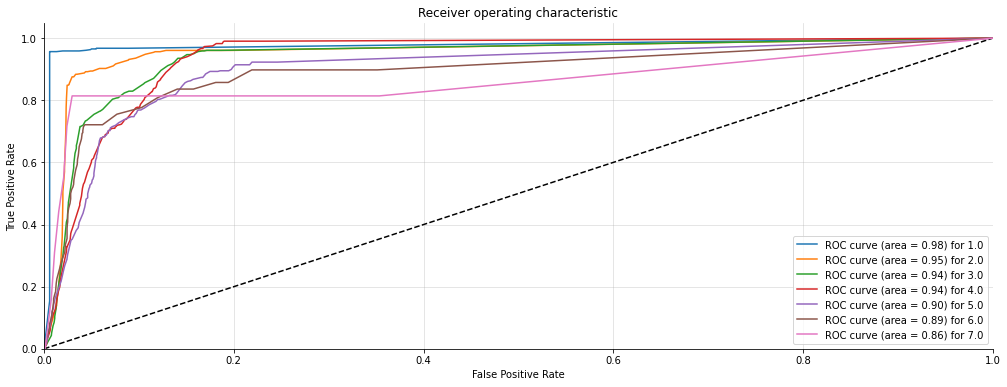

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.83      0.88      0.85       485
         3.0       0.75      0.72      0.73       501
         4.0       0.68      0.69      0.69       515
         5.0       0.70      0.72      0.71       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  4 425  51   0   1   4   0]
 [  0  18 360 119   4   0   0]
 [  0   3  31 354 125   2   0]
 [  3  13  16  28 330  70   0]
 [  5  17  16  13   6 384  43]
 [  9  19   5   4   5   2 408]]
Accuracy Score : 0.8044642857142857
Precision Score : 0.804565913322212
Recall Score : 0.8044642857142857
F1 Score : 0.80427728111189

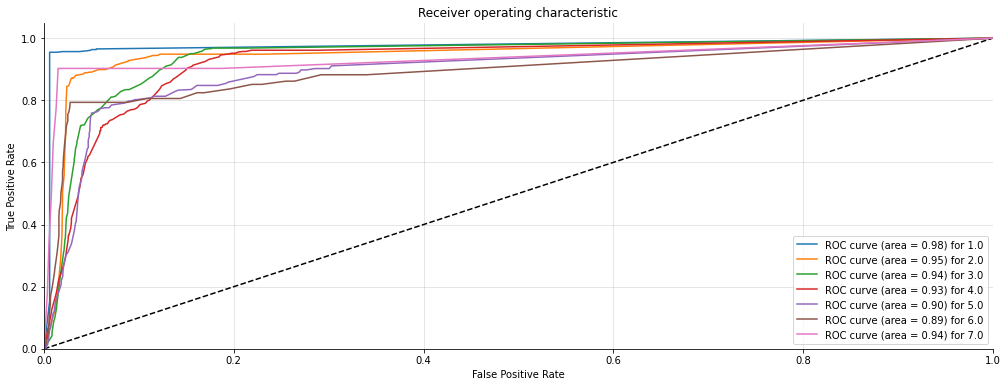

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.83      0.88      0.85       482
         3.0       0.75      0.72      0.73       506
         4.0       0.68      0.67      0.67       526
         5.0       0.66      0.66      0.66       458
         6.0       0.72      0.71      0.71       475
         7.0       0.82      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  4 425  51   1   0   1   0]
 [  0  18 362 119   1   3   3]
 [  0   3  29 350 144   0   0]
 [  2   5   6  24 304 117   0]
 [  6  17  22  11   7 335  77]
 [  9  28  14  12   8   6 374]]
Accuracy Score : 0.7714285714285715
Precision Score : 0.7704285240244723
Recall Score : 0.7714285714285715
F1 Score : 0.77071046

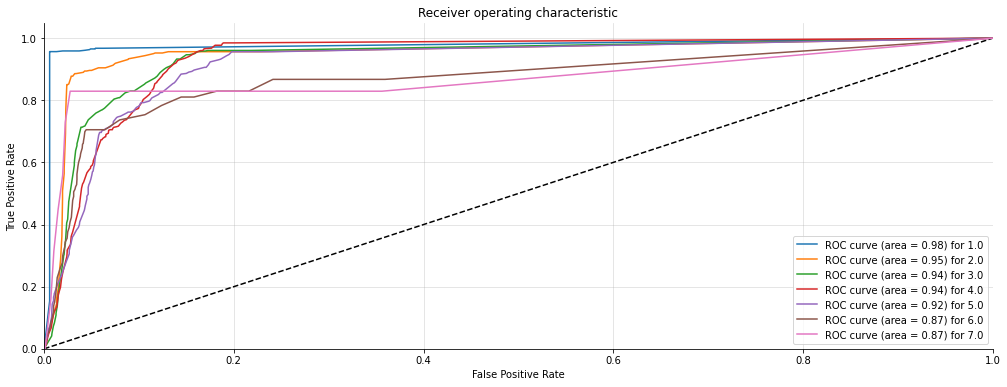

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       461
         2.0       0.83      0.87      0.85       488
         3.0       0.75      0.71      0.73       506
         4.0       0.67      0.67      0.67       516
         5.0       0.66      0.67      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.80      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  4 425  52   2   2   3   0]
 [  0  19 361 122   0   1   3]
 [  0   1  24 344 145   2   0]
 [  2   2   8  24 307 113   0]
 [  2  14  18   8   4 339  86]
 [ 13  35  21  15   9   4 365]]
Accuracy Score : 0.76875
Precision Score : 0.7683602863694446
Recall Score : 0.76875
F1 Score : 0.768380249634554
(3360, 7) (3360, 7)

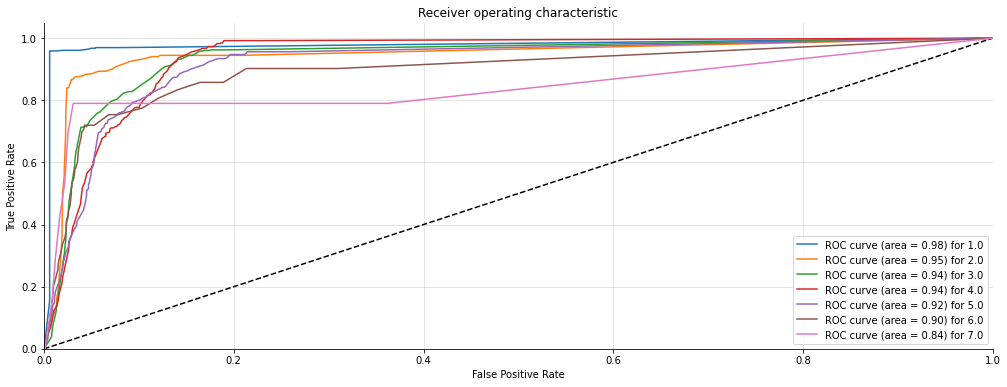

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.89      0.88       491
         3.0       0.83      0.80      0.82       487
         4.0       0.86      0.87      0.86       518
         5.0       0.92      0.92      0.92       487
         6.0       0.95      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 435  44   3   1   3   0]
 [  7  27 390  58   2   3   0]
 [  3  15  17 451  31   1   0]
 [  1   5  11  13 446  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9086309523809524
Precision Score : 0.9085680334842574
Recall Score : 0.9086309523809524
F1 Score : 0.90852487367335

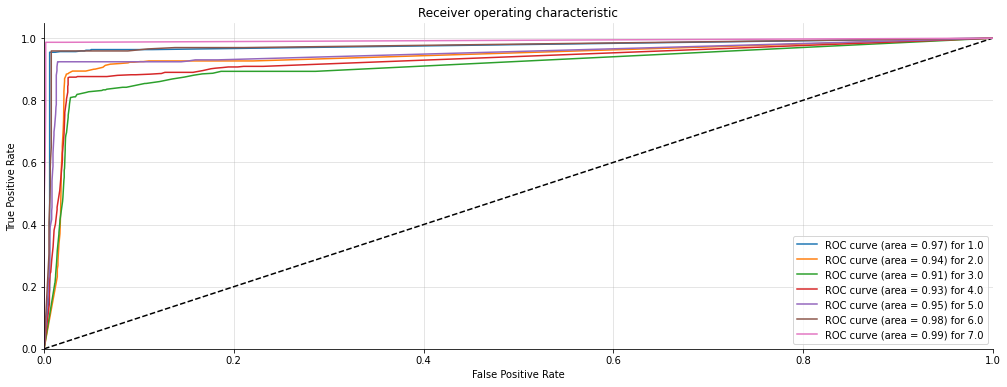

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.87       495
         3.0       0.82      0.78      0.80       490
         4.0       0.82      0.84      0.83       519
         5.0       0.89      0.90      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 432  49   3   2   4   0]
 [  7  26 384  69   0   4   0]
 [  3  17  17 436  46   0   0]
 [  1   7  11  19 432  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8979166666666667
Precision Score : 0.8977050792040955
Recall Score : 0.8979166666666667
F1 Score : 0.89

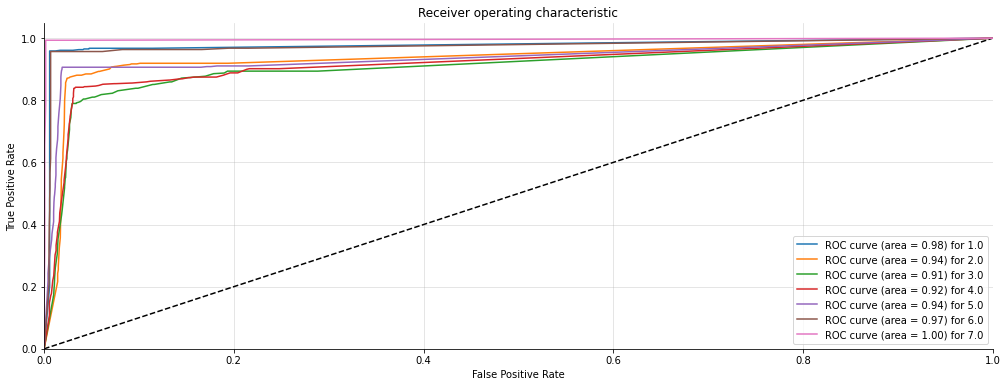

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.94       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  6 478  15   2   1   0   0]
 [  0  13 448  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9708333333333333
Precision Score : 0.9708090759968673
Recall Score : 0.9708333333333333
F1 Score : 0.9708113

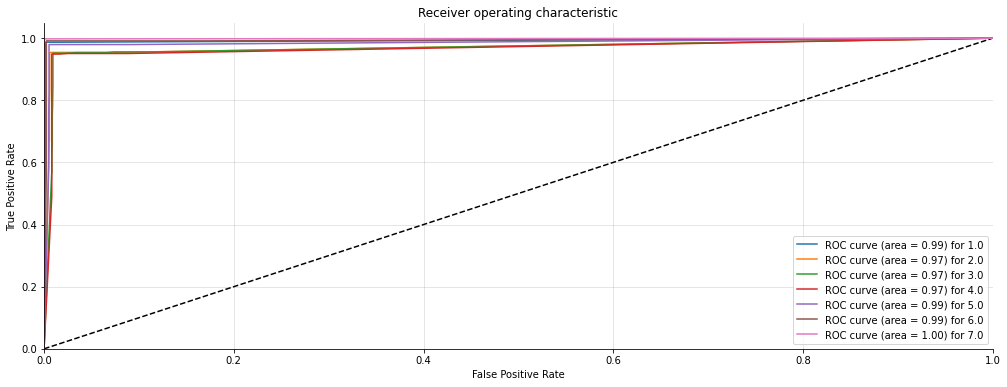

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


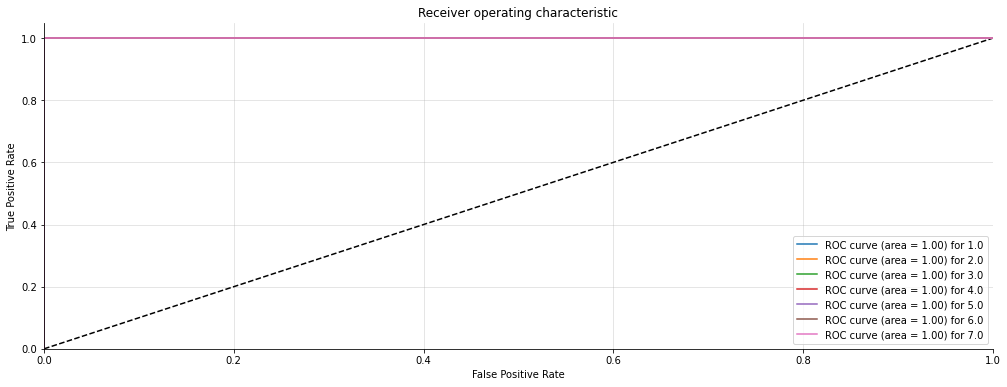

In [86]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def ETC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = ExtraTreesClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ETC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [87]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['ExtraTreesClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8616071428571428
average Precision :0.8613069115834746
average Recall :0.8616071428571428
average F1 -score :0.8613245352824729
average RMSE 0.6038498676558416
average AUC score 0.919074296026043


# 4.7.4 Adaboost 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.63      0.73      0.68       462
         2.0       0.39      0.49      0.44       482
         3.0       0.33      0.28      0.30       510
         4.0       0.36      0.29      0.32       517
         5.0       0.33      0.31      0.32       467
         6.0       0.43      0.38      0.40       470
         7.0       0.74      0.82      0.78       452

    accuracy                           0.47      3360
   macro avg       0.46      0.47      0.46      3360
weighted avg       0.45      0.47      0.46      3360

Confusion Matrix: 
 [[339  50  17  17  10  25   4]
 [ 64 238  53  45  44  36   2]
 [ 49 109 145  98  51  47  11]
 [ 20  89 118 149 102  36   3]
 [ 30  68  52  78 145  86   8]
 [ 18  33  40  20  80 179 100]
 [ 16  17  18   8  13  11 369]]
Accuracy Score : 0.4654761904761905
Precision Score : 0.45319768547350253
Recall Score : 0.4654761904761905
F1 Score : 0.456751

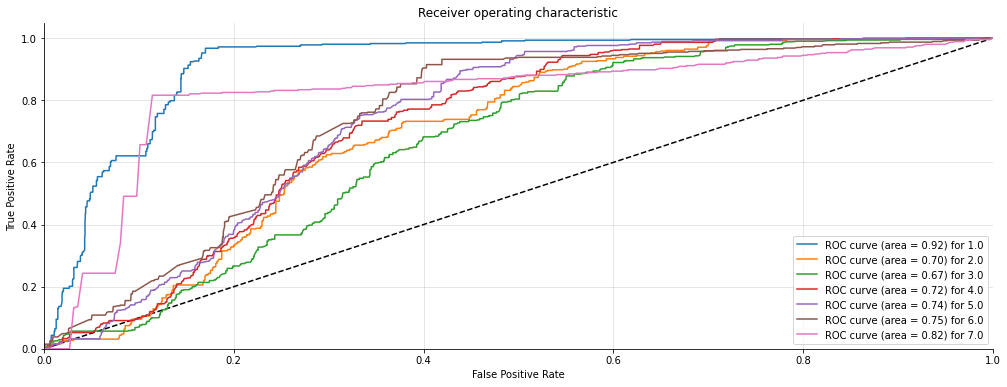

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.66      0.71      0.68       463
         2.0       0.41      0.44      0.42       485
         3.0       0.31      0.29      0.30       501
         4.0       0.37      0.34      0.35       515
         5.0       0.34      0.39      0.36       460
         6.0       0.48      0.45      0.46       484
         7.0       0.83      0.78      0.80       452

    accuracy                           0.48      3360
   macro avg       0.49      0.48      0.48      3360
weighted avg       0.48      0.48      0.48      3360

Confusion Matrix: 
 [[330  43  32  13  16  22   7]
 [ 58 213  69  48  51  33  13]
 [ 46  86 146 113  71  30   9]
 [ 22  58 110 174 120  28   3]
 [ 28  67  57  73 179  54   2]
 [  8  42  56  46  78 216  38]
 [ 10  11   8   2   6  64 351]]
Accuracy Score : 0.47886904761904764
Precision Score : 0.4803876383715544
Recall Score : 0.47886904761904764
F1 Score : 0.47883823234

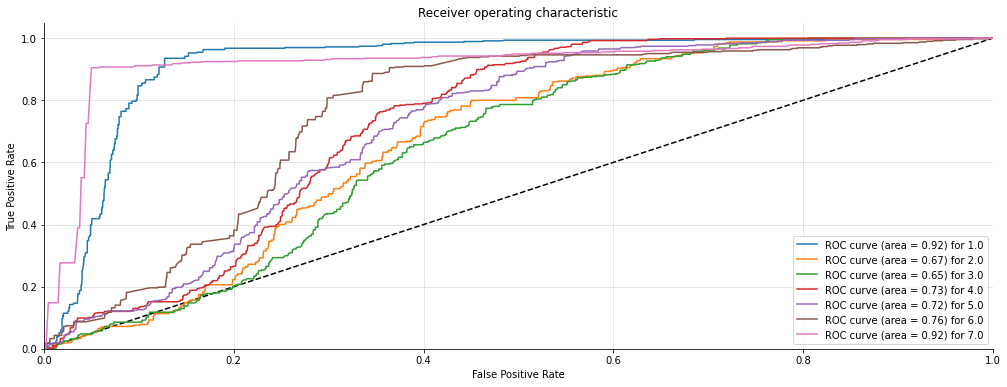

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.61      0.69      0.64       462
         2.0       0.34      0.40      0.37       482
         3.0       0.31      0.31      0.31       506
         4.0       0.39      0.33      0.36       526
         5.0       0.34      0.33      0.33       458
         6.0       0.46      0.43      0.44       475
         7.0       0.64      0.59      0.61       451

    accuracy                           0.44      3360
   macro avg       0.44      0.44      0.44      3360
weighted avg       0.44      0.44      0.44      3360

Confusion Matrix: 
 [[318  48  34  20  22  18   2]
 [ 69 195  72  54  44  32  16]
 [ 53  89 159  97  64  27  17]
 [ 23  70 115 176 107  23  12]
 [ 29  53  54  70 151  82  19]
 [ 16  38  63  21  53 203  81]
 [ 17  78  13  11   9  59 264]]
Accuracy Score : 0.4363095238095238
Precision Score : 0.4371823875682985
Recall Score : 0.4363095238095238
F1 Score : 0.43539368

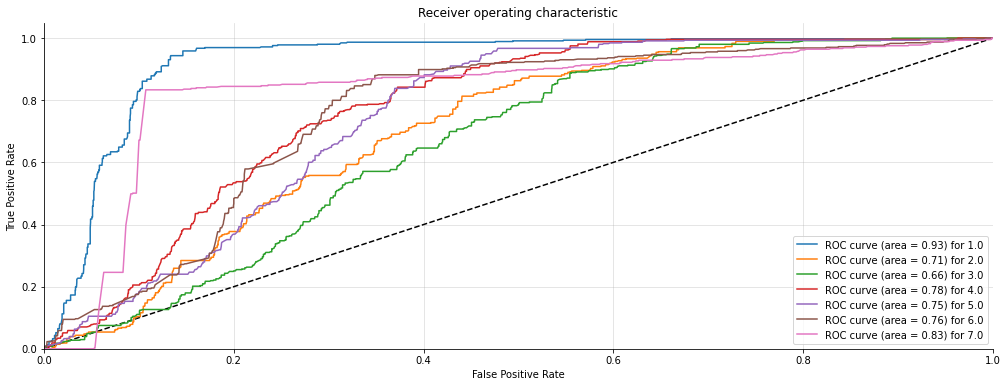

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.65      0.76      0.70       461
         2.0       0.36      0.43      0.39       488
         3.0       0.32      0.34      0.33       506
         4.0       0.38      0.30      0.33       516
         5.0       0.34      0.31      0.32       456
         6.0       0.46      0.44      0.45       471
         7.0       0.73      0.66      0.69       462

    accuracy                           0.46      3360
   macro avg       0.46      0.46      0.46      3360
weighted avg       0.46      0.46      0.46      3360

Confusion Matrix: 
 [[349  39  25  18   9  19   2]
 [ 65 209  63  48  48  42  13]
 [ 44 102 174  86  58  29  13]
 [ 24  67 134 154  88  45   4]
 [ 25  49  70  66 141 101   4]
 [ 14  37  58  18  59 206  79]
 [ 18  83  17  17  16   5 306]]
Accuracy Score : 0.45803571428571427
Precision Score : 0.45739327580826733
Recall Score : 0.45803571428571427
F1 Score : 0.4555456111

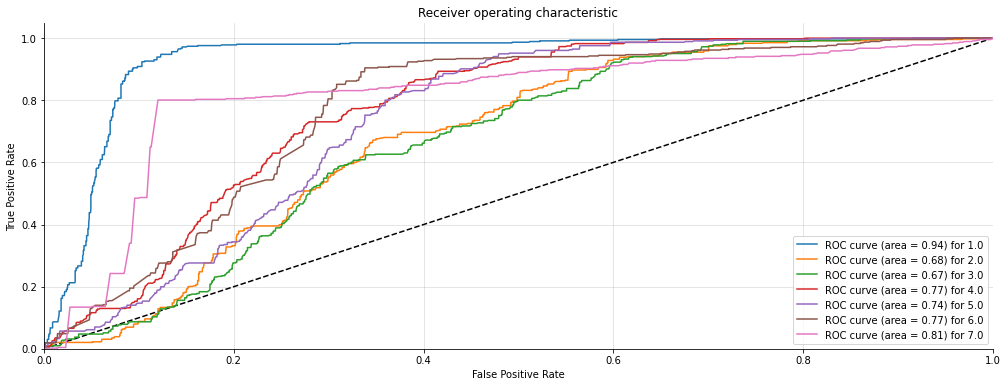

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.29      0.44      0.35       463
         2.0       0.25      0.26      0.25       491
         3.0       0.24      0.19      0.21       487
         4.0       0.28      0.22      0.25       518
         5.0       0.24      0.23      0.24       487
         6.0       0.25      0.24      0.24       462
         7.0       0.97      0.99      0.98       452

    accuracy                           0.36      3360
   macro avg       0.36      0.37      0.36      3360
weighted avg       0.35      0.36      0.35      3360

Confusion Matrix: 
 [[202  72  61  46  34  48   0]
 [103 127  65  62  56  75   3]
 [104  74  92  46  96  72   3]
 [ 93  87  79 114  73  71   1]
 [ 98 118  34  61 113  63   0]
 [ 89  32  56  72  99 109   5]
 [  2   2   2   0   0   0 446]]
Accuracy Score : 0.3580357142857143
Precision Score : 0.35462721963426264
Recall Score : 0.3580357142857143
F1 Score : 0.3533006577475

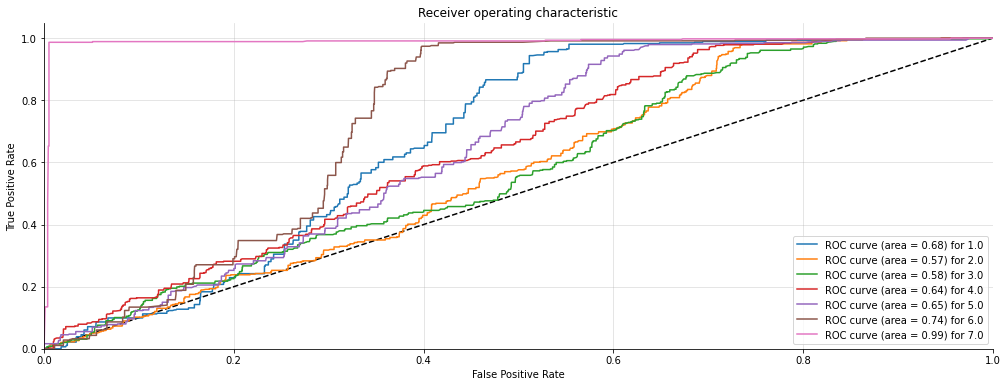

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.25      0.40      0.31       461
         2.0       0.23      0.13      0.17       495
         3.0       0.17      0.20      0.18       490
         4.0       0.28      0.29      0.29       519
         5.0       0.26      0.27      0.26       481
         6.0       0.31      0.22      0.26       465
         7.0       0.93      0.86      0.89       449

    accuracy                           0.33      3360
   macro avg       0.35      0.34      0.34      3360
weighted avg       0.34      0.33      0.33      3360

Confusion Matrix: 
 [[185  26  50  84  66  50   0]
 [135  64  95  71  72  54   4]
 [114  61  96 113  67  27  12]
 [ 94  61  82 152  85  43   2]
 [106  34  98  65 130  48   0]
 [105  29  72  59  88 102  10]
 [  0   0  63   0   1   0 385]]
Accuracy Score : 0.33154761904761904
Precision Score : 0.34167318759822357
Recall Score : 0.33154761904761904
F1 Score : 0

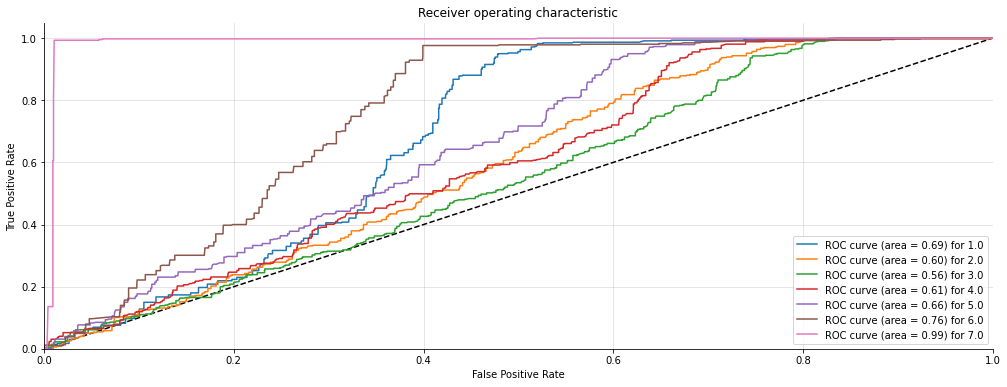

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.22      0.45      0.29       460
         2.0       0.27      0.18      0.22       502
         3.0       0.16      0.13      0.14       474
         4.0       0.23      0.21      0.22       527
         5.0       0.14      0.16      0.15       486
         6.0       0.28      0.25      0.27       459
         7.0       0.97      0.56      0.71       452

    accuracy                           0.27      3360
   macro avg       0.33      0.28      0.29      3360
weighted avg       0.32      0.27      0.28      3360

Confusion Matrix: 
 [[206  43  53  77  69  12   0]
 [168  92  46  61  89  45   1]
 [157  45  62  51 105  54   0]
 [183  57  47 112  76  52   0]
 [123  54  87  70  76  69   7]
 [105  44  98  53  42 117   0]
 [  1   0   0  60  73  64 254]]
Accuracy Score : 0.2735119047619048
Precision Score : 0.3193452520655683
Recall Score : 0.2735119047619048
F1 Score : 0.2819838

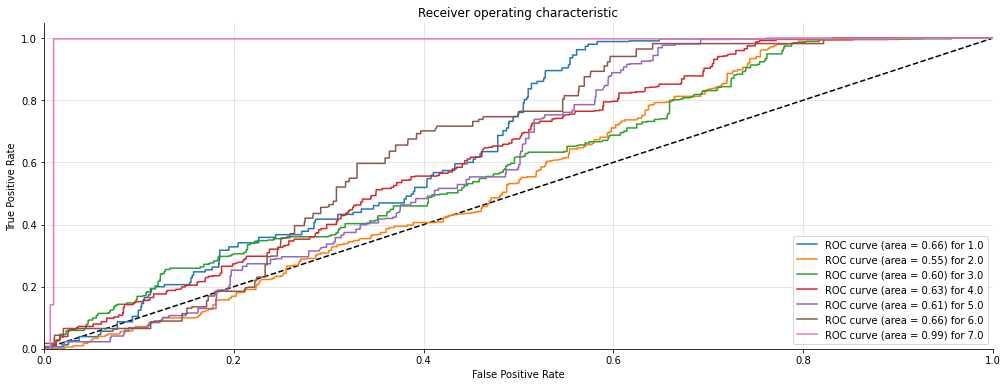

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.33      0.27      0.30       459
         2.0       0.30      0.18      0.23       496
         3.0       0.22      0.26      0.24       478
         4.0       0.16      0.18      0.17       523
         5.0       0.16      0.25      0.20       491
         6.0       0.21      0.24      0.23       462
         7.0       0.98      0.55      0.71       451

    accuracy                           0.27      3360
   macro avg       0.34      0.28      0.29      3360
weighted avg       0.33      0.27      0.29      3360

Confusion Matrix: 
 [[124  42  62  52 121  58   0]
 [ 38  89  94  70 135  70   0]
 [ 55  48 122  38 117  97   1]
 [ 51  58  96  93 142  78   5]
 [ 61  29  81  70 124 126   0]
 [ 48  29  91  43 138 113   0]
 [  0   0   0 202   0   0 249]]
Accuracy Score : 0.2720238095238095
Precision Score : 0.3297965649312163
Recall Score : 0.2720238095238095
F1 Score : 0.28839163790

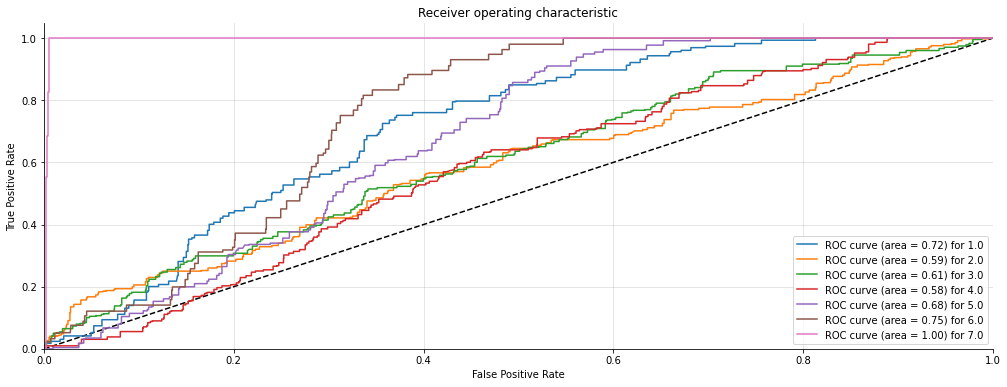

In [88]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def ADB(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = AdaBoostClassifier(n_estimators=500)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ADB(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [89]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['AdaBoost'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.38422619047619044
average Precision :0.3967004014313617
average Recall :0.38422619047619044
average F1 -score :0.3850861047792276
average RMSE 1.9452360317551016
average AUC score 0.6403180429994433


# 4.7.5 Gradient boosting 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.51      0.80      0.62       462
         2.0       0.45      0.45      0.45       482
         3.0       0.34      0.19      0.24       510
         4.0       0.35      0.29      0.32       517
         5.0       0.32      0.28      0.30       467
         6.0       0.51      0.61      0.56       470
         7.0       0.78      0.82      0.80       452

    accuracy                           0.48      3360
   macro avg       0.47      0.49      0.47      3360
weighted avg       0.46      0.48      0.46      3360

Confusion Matrix: 
 [[370  36   5  22   5  21   3]
 [ 79 217  44  47  45  38  12]
 [ 92 103  97 110  69  36   3]
 [ 68  48  80 152 128  41   0]
 [ 60  36  37  72 133 129   0]
 [ 30  25  13  16  16 286  84]
 [ 26  15   7  12  15   8 369]]
Accuracy Score : 0.48333333333333334
Precision Score : 0.46325000522049553
Recall Score : 0.48333333333333334
F1 Score : 0.4643

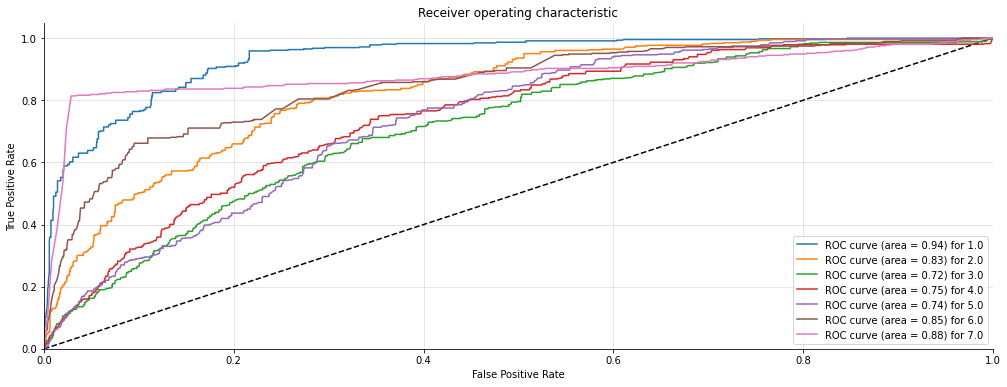

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.49      0.79      0.61       463
         2.0       0.26      0.14      0.18       485
         3.0       0.28      0.24      0.26       501
         4.0       0.34      0.28      0.31       515
         5.0       0.25      0.22      0.24       460
         6.0       0.31      0.43      0.36       484
         7.0       0.76      0.76      0.76       452

    accuracy                           0.40      3360
   macro avg       0.39      0.41      0.39      3360
weighted avg       0.38      0.40      0.38      3360

Confusion Matrix: 
 [[368  26   8  10  11  33   7]
 [103  69 114  56  62  60  21]
 [ 77  55 118  82  64  90  15]
 [ 78  34  83 144  76  85  15]
 [ 58  41  45  94 101 116   5]
 [ 47  34  38  34  80 206  45]
 [ 14   5  10   3   4  74 342]]
Accuracy Score : 0.4011904761904762
Precision Score : 0.38193593453810754
Recall Score : 0.4011904761904762
F1 Score : 0.381925714436

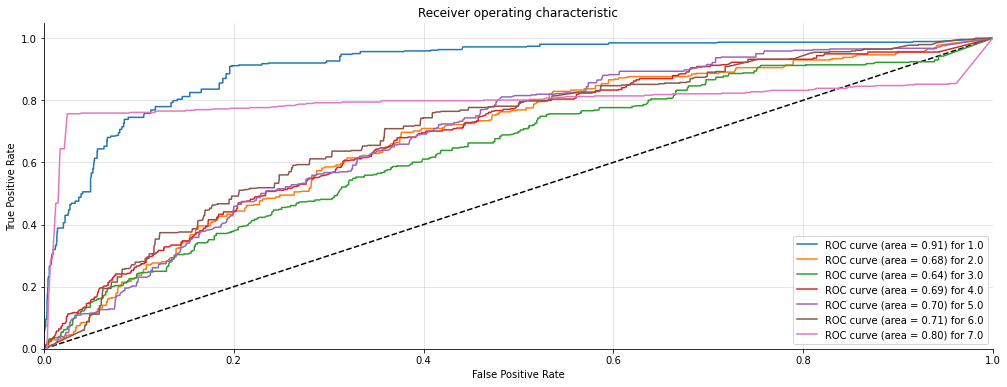

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.52      0.84      0.64       462
         2.0       0.42      0.40      0.41       482
         3.0       0.34      0.22      0.27       506
         4.0       0.34      0.25      0.29       526
         5.0       0.32      0.29      0.30       458
         6.0       0.52      0.61      0.56       475
         7.0       0.81      0.83      0.82       451

    accuracy                           0.48      3360
   macro avg       0.47      0.49      0.47      3360
weighted avg       0.46      0.48      0.47      3360

Confusion Matrix: 
 [[390  31   3  14  17   7   0]
 [101 192  62  41  47  33   6]
 [ 84  96 113  93  70  45   5]
 [ 69  53  99 134 124  46   1]
 [ 53  35  28  85 133 124   0]
 [ 30  29  17  15  16 291  77]
 [ 21  17  12   8   8  10 375]]
Accuracy Score : 0.4845238095238095
Precision Score : 0.46338510060909643
Recall Score : 0.4845238095238095
F1 Score : 0.4652283

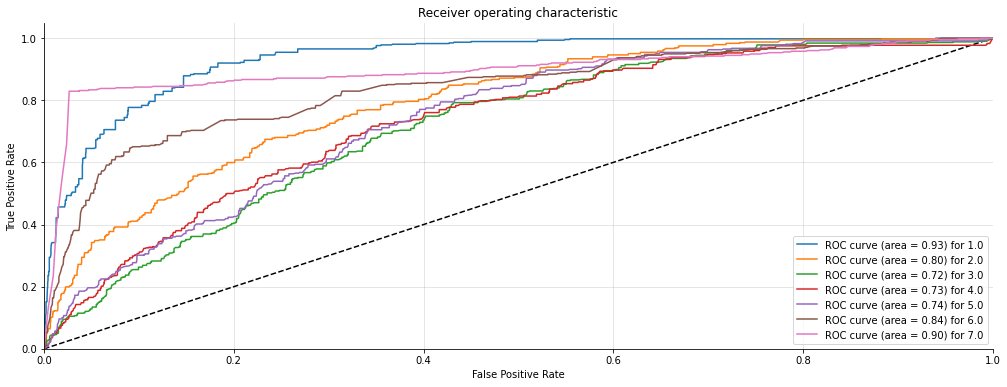

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.50      0.82      0.62       461
         2.0       0.39      0.32      0.35       488
         3.0       0.36      0.25      0.29       506
         4.0       0.35      0.28      0.31       516
         5.0       0.40      0.41      0.40       456
         6.0       0.53      0.61      0.57       471
         7.0       0.79      0.79      0.79       462

    accuracy                           0.49      3360
   macro avg       0.48      0.50      0.48      3360
weighted avg       0.47      0.49      0.47      3360

Confusion Matrix: 
 [[376  36  10  13   7  19   0]
 [ 95 156  82  64  49  37   5]
 [ 85 104 125 101  43  44   4]
 [ 75  56  71 143 132  39   0]
 [ 62  16  21  68 185 104   0]
 [ 35  10  16   9  28 287  86]
 [ 23  23  18  10  15   7 366]]
Accuracy Score : 0.4875
Precision Score : 0.47268411222517326
Recall Score : 0.4875
F1 Score : 0.4717294678080534
(3360, 7) (3360, 7)

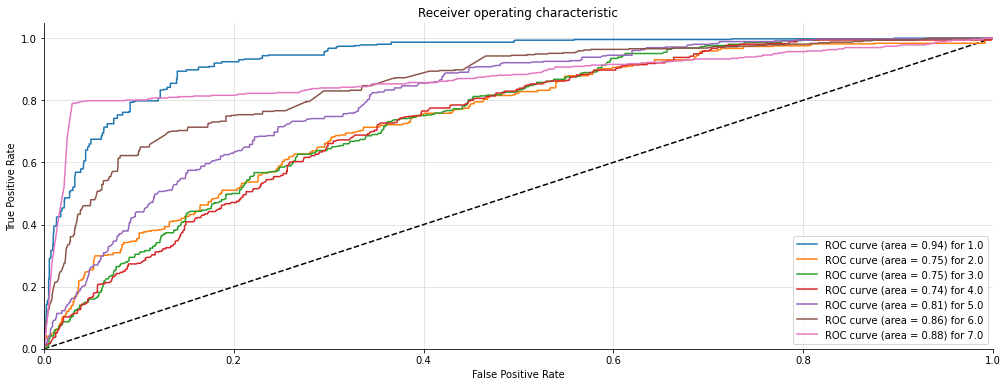

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.44      0.63      0.52       463
         2.0       0.34      0.27      0.30       491
         3.0       0.35      0.23      0.28       487
         4.0       0.43      0.38      0.40       518
         5.0       0.27      0.28      0.27       487
         6.0       0.51      0.67      0.58       462
         7.0       0.90      0.83      0.86       452

    accuracy                           0.46      3360
   macro avg       0.46      0.47      0.46      3360
weighted avg       0.46      0.46      0.45      3360

Confusion Matrix: 
 [[292  47  20  19  32  50   3]
 [ 89 131  68  54  85  44  20]
 [ 76  79 111  82  81  51   7]
 [ 66  54  60 196  70  72   0]
 [ 74  65  34  89 137  83   5]
 [ 60  10  24  15  37 309   7]
 [  2   0   2   1  73   1 373]]
Accuracy Score : 0.4610119047619048
Precision Score : 0.45646760916572143
Recall Score : 0.4610119047619048
F1 Score : 0.4519992314482

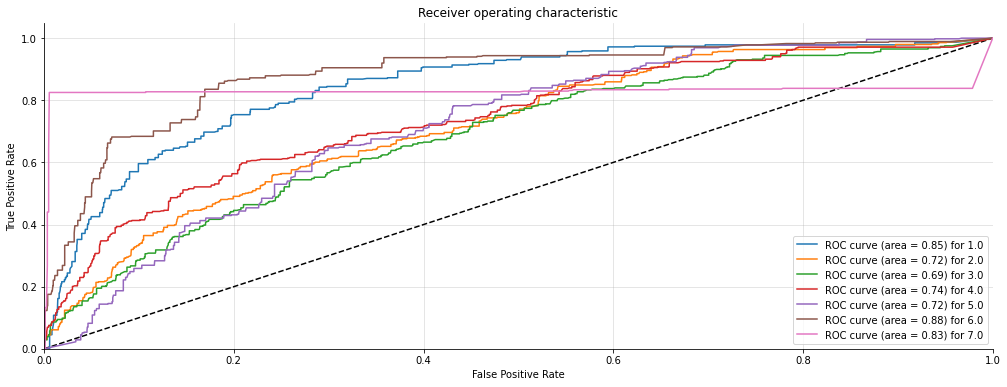

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.60      0.83      0.70       461
         2.0       0.46      0.39      0.43       495
         3.0       0.57      0.36      0.44       490
         4.0       0.59      0.54      0.57       519
         5.0       0.61      0.61      0.61       481
         6.0       0.72      0.90      0.80       465
         7.0       0.95      0.99      0.97       449

    accuracy                           0.65      3360
   macro avg       0.65      0.66      0.64      3360
weighted avg       0.64      0.65      0.64      3360

Confusion Matrix: 
 [[381  24   5  15  23  13   0]
 [ 78 195  62  52  56  50   2]
 [ 63  90 177  83  47  25   5]
 [ 74  51  28 281  53  28   4]
 [ 33  47  23  41 292  43   2]
 [  3  13  15   2   5 417  10]
 [  0   1   1   0   0   1 446]]
Accuracy Score : 0.6514880952380953
Precision Score : 0.6404302237754793
Recall Score : 0.6514880952380953
F1 Score : 0.63

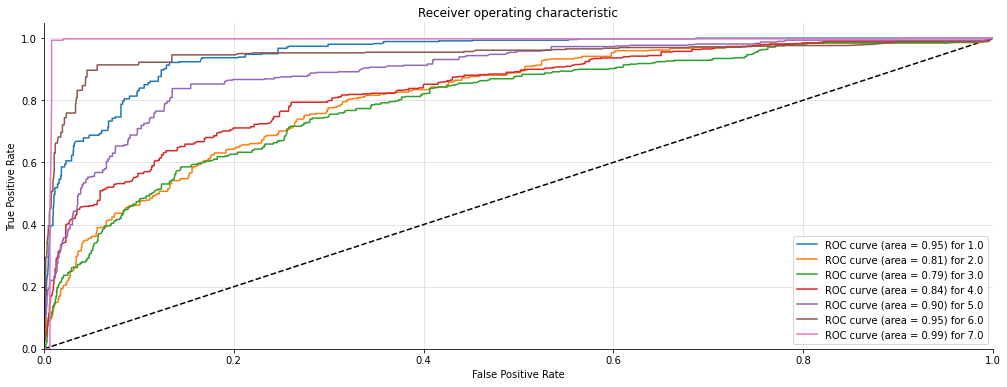

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.47      0.62      0.53       460
         2.0       0.36      0.29      0.32       502
         3.0       0.41      0.34      0.37       474
         4.0       0.48      0.34      0.40       527
         5.0       0.23      0.22      0.23       486
         6.0       0.54      0.66      0.59       459
         7.0       0.68      0.84      0.75       452

    accuracy                           0.46      3360
   macro avg       0.45      0.47      0.46      3360
weighted avg       0.45      0.46      0.45      3360

Confusion Matrix: 
 [[283  48  23  18  22  38  28]
 [ 81 145  65  36  94  35  46]
 [ 49  70 161  54  68  34  38]
 [ 77  65  36 180  62  76  31]
 [ 70  75  62  78 109  72  20]
 [ 37   1  48  12  41 301  19]
 [  1   0   0   0  73   0 378]]
Accuracy Score : 0.46339285714285716
Precision Score : 0.4489750968844156
Recall Score : 0.46339285714285716
F1 Score : 0.45026

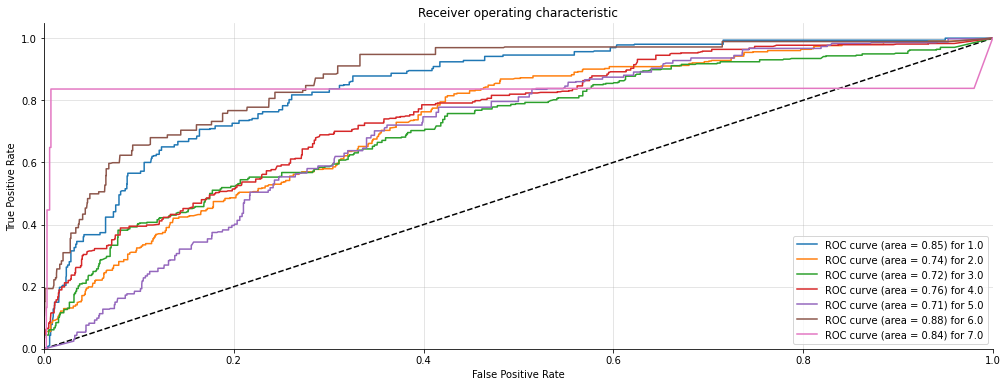

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.59      0.77      0.67       459
         2.0       0.41      0.24      0.30       496
         3.0       0.35      0.31      0.33       478
         4.0       0.59      0.58      0.58       523
         5.0       0.28      0.30      0.29       491
         6.0       0.56      0.65      0.60       462
         7.0       0.79      0.84      0.81       451

    accuracy                           0.52      3360
   macro avg       0.51      0.53      0.51      3360
weighted avg       0.51      0.52      0.51      3360

Confusion Matrix: 
 [[354  24  13  13  20  26   9]
 [ 81 117  85  62  82  46  23]
 [ 42  55 148  60 102  43  28]
 [ 46  23  32 305  49  52  16]
 [ 56  53  93  68 145  69   7]
 [ 26  15  50  12  38 302  19]
 [  0   0   0   0  73   0 378]]
Accuracy Score : 0.5205357142857143
Precision Score : 0.5059359226611814
Recall Score : 0.5205357142857143
F1 Score : 0.50731526720

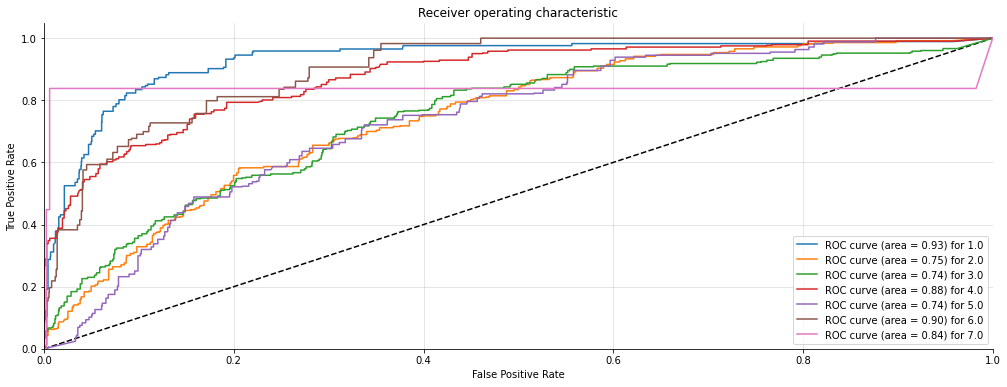

In [90]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def GBC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  GBC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [91]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['GradientBoost'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.4941220238095238
average Precision :0.47913300063495884
average Recall :0.4941220238095238
average F1 -score :0.47887732297852714
average RMSE 1.7239352237266319
average AUC score 0.7047689224483402


# 4.7.6  Bagging classfier

In [92]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       462
         2.0       0.80      0.86      0.83       482
         3.0       0.74      0.69      0.71       510
         4.0       0.66      0.66      0.66       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  7 413  57   4   0   1   0]
 [  1  31 351 120   3   4   0]
 [  0   2  24 343 146   2   0]
 [  5   6  13  27 304 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  26  19  12  11   6 368]]
Accuracy Score : 0.7619047619047619
Precision Score : 0.7610152317301411
Recall Score : 0.7619047619047619
F1 Score : 0.7611416

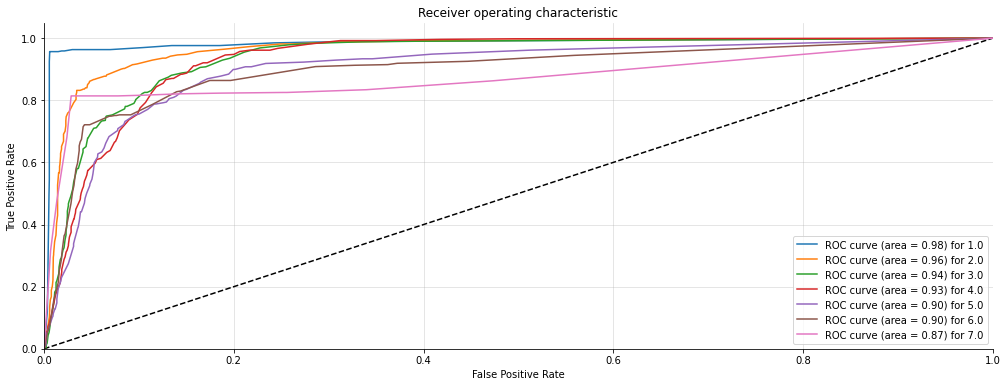

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.82      0.85      0.83       485
         3.0       0.73      0.71      0.72       501
         4.0       0.67      0.66      0.66       515
         5.0       0.69      0.72      0.70       460
         6.0       0.82      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.79      3360
   macro avg       0.80      0.80      0.80      3360
weighted avg       0.79      0.79      0.79      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  5 411  57   4   2   6   0]
 [  0  20 358 116   4   3   0]
 [  0   2  39 338 134   2   0]
 [  3  12  17  28 330  70   0]
 [  5  18  13  15   6 384  43]
 [  9  19   6   3   5   2 408]]
Accuracy Score : 0.7949404761904761
Precision Score : 0.7949905306430801
Recall Score : 0.7949404761904761
F1 Score : 0.7948237225289

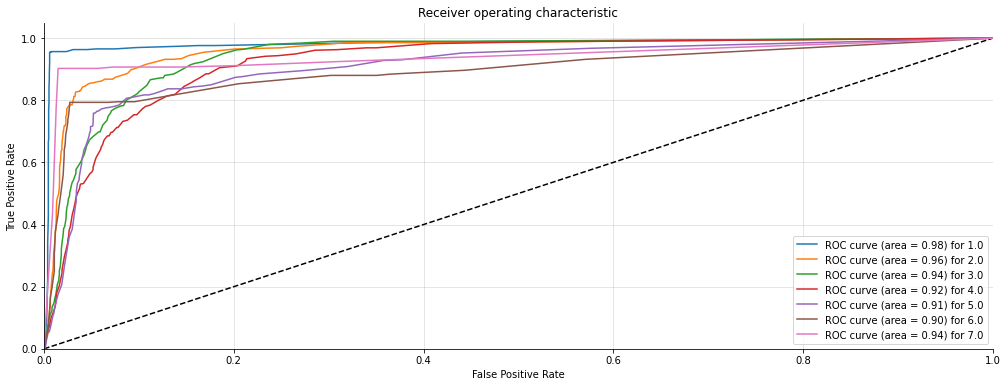

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       462
         2.0       0.82      0.86      0.84       482
         3.0       0.75      0.71      0.73       506
         4.0       0.65      0.67      0.66       526
         5.0       0.62      0.64      0.63       458
         6.0       0.72      0.67      0.70       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[443  18   0   0   0   1   0]
 [  8 416  53   1   2   1   1]
 [  0  18 358 123   2   5   0]
 [  0   5  27 351 143   0   0]
 [  2   5   6  40 293 112   0]
 [  6  18  19  13  22 320  77]
 [  9  28  14  12   8   6 374]]
Accuracy Score : 0.7604166666666666
Precision Score : 0.7601068816711244
Recall Score : 0.7604166666666666
F1 Score : 0.75994056

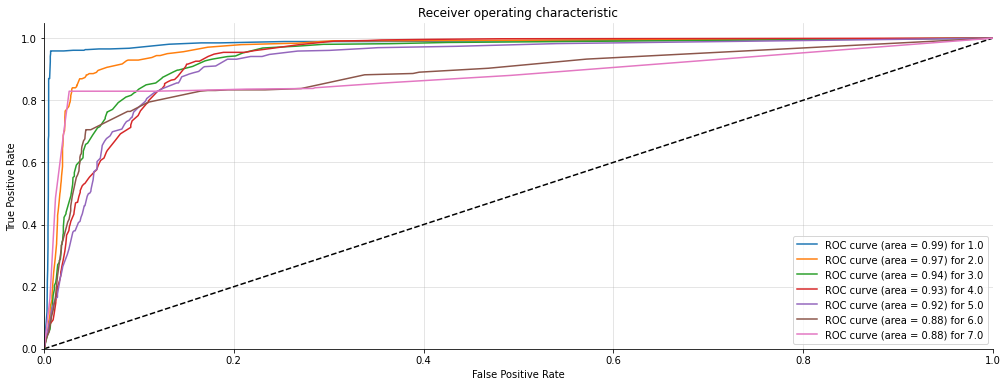

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       461
         2.0       0.82      0.84      0.83       488
         3.0       0.72      0.72      0.72       506
         4.0       0.66      0.65      0.66       516
         5.0       0.65      0.67      0.66       456
         6.0       0.73      0.70      0.71       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[444  17   0   0   0   0   0]
 [  6 411  60   6   1   3   1]
 [  3  18 364 116   0   5   0]
 [  0   1  34 337 142   2   0]
 [  2   2   8  27 306 111   0]
 [  3  15  17   7  13 330  86]
 [ 13  35  20  16   9   4 365]]
Accuracy Score : 0.7610119047619047
Precision Score : 0.7604919862615395
Recall Score : 0.7610119047619047
F1 Score : 0.7606497471576

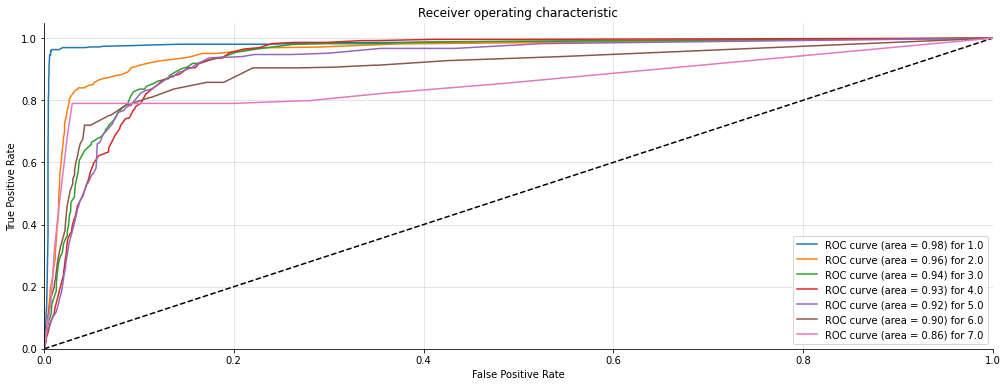

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.83      0.85      0.84       491
         3.0       0.82      0.75      0.79       487
         4.0       0.85      0.86      0.86       518
         5.0       0.89      0.92      0.91       487
         6.0       0.95      0.96      0.95       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  8 418  46   8   8   3   0]
 [  8  42 367  60   5   5   0]
 [  3  15  16 447  35   2   0]
 [  1   6   9  10 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.8967261904761905
Precision Score : 0.8961237852749252
Recall Score : 0.8967261904761905
F1 Score : 0.89612345903321

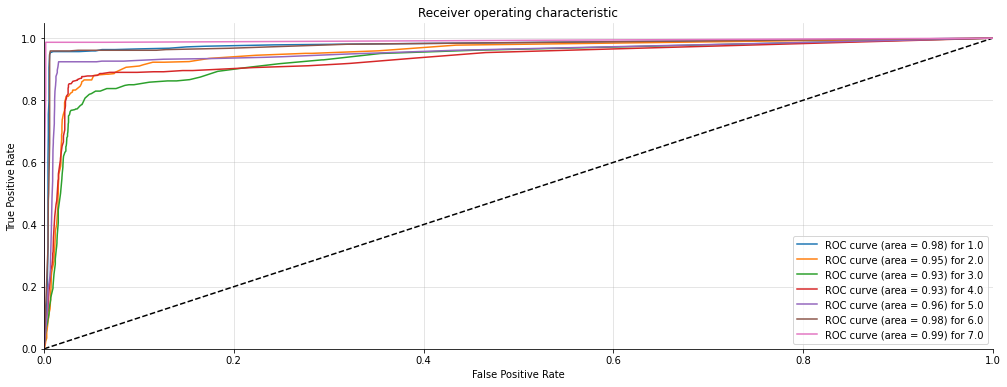

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       461
         2.0       0.85      0.84      0.85       495
         3.0       0.81      0.77      0.79       490
         4.0       0.82      0.83      0.82       519
         5.0       0.88      0.90      0.89       481
         6.0       0.94      0.96      0.95       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.89      3360
   macro avg       0.89      0.89      0.89      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[442  17   2   0   0   0   0]
 [ 12 416  52   6   5   4   0]
 [  7  29 376  70   2   6   0]
 [  4  17  19 429  46   4   0]
 [  1   7  10  20 432  11   0]
 [  1   2   4   1   6 446   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8889880952380952
Precision Score : 0.8882153976320305
Recall Score : 0.8889880952380952
F1 Score : 0.88

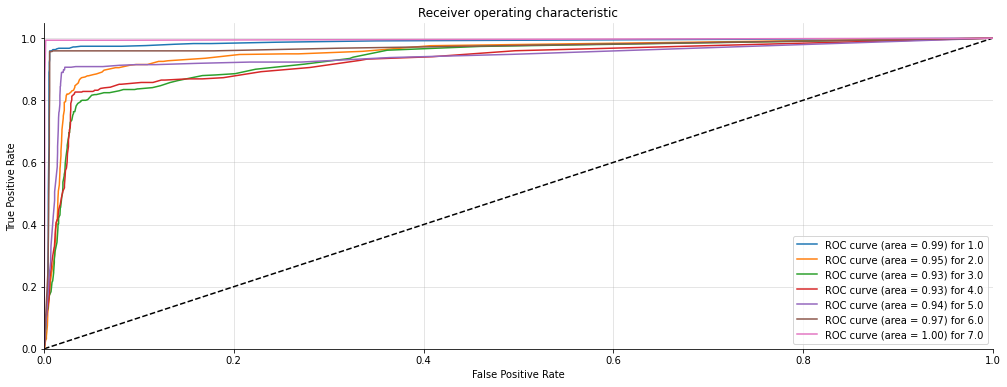

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.98       460
         2.0       0.96      0.93      0.94       502
         3.0       0.95      0.93      0.94       474
         4.0       0.95      0.94      0.95       527
         5.0       0.95      0.98      0.96       486
         6.0       0.98      0.99      0.98       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.96      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.96      0.96      0.96      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [ 11 468  15   4   4   0   0]
 [  0  14 442  13   2   3   0]
 [  0   2  10 495  15   5   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9645833333333333
Precision Score : 0.964518444139767
Recall Score : 0.9645833333333333
F1 Score : 0.96447227

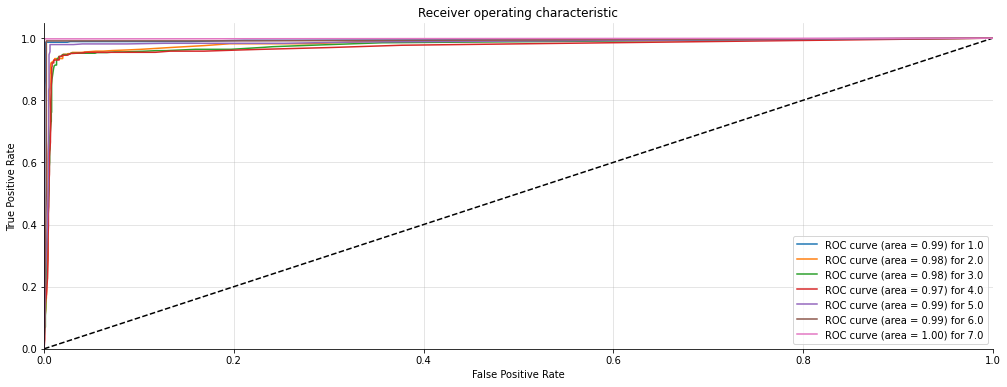

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       459
         2.0       1.00      0.98      0.99       496
         3.0       0.99      0.97      0.98       478
         4.0       0.99      0.99      0.99       523
         5.0       0.99      1.00      0.99       491
         6.0       0.99      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.99      3360
   macro avg       0.99      0.99      0.99      3360
weighted avg       0.99      0.99      0.99      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  3 484   7   2   0   0   0]
 [  2   2 466   1   4   3   0]
 [  0   0   0 519   3   1   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.9916666666666667
Precision Score : 0.9916862239544968
Recall Score : 0.9916666666666667
F1 Score : 0.99164355838

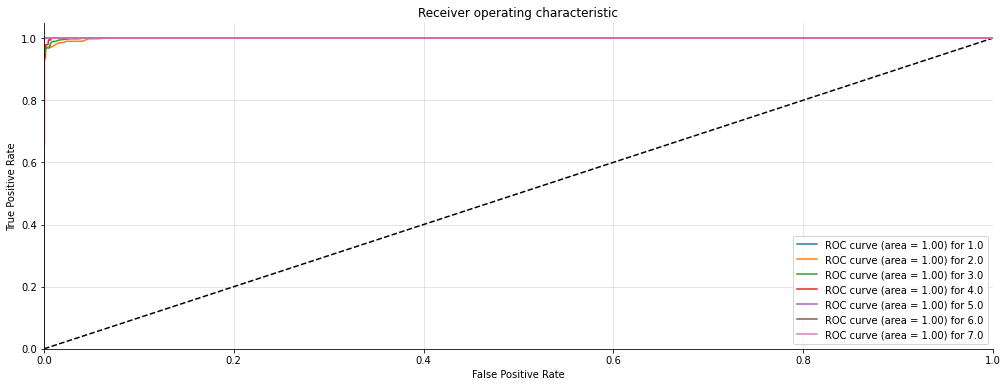

In [93]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def BAG(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  BAG(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [94]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['BaggingClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8525297619047618
average Precision :0.8521435601633881
average Recall :0.8525297619047618
average F1 -score :0.8521598779730053
average RMSE 0.6439959250849004
average AUC score 0.913766601485031


In [95]:
metric_df

metric  Neural network classifier       XGB       SVM  OrdinalModel  \
0   Accuracy                   0.743118  0.863653  0.664472      0.863467   
1  Precision                   0.759766  0.863599  0.687557      0.863370   
2     Recall                   0.743118  0.863653  0.664472      0.863467   
3   F1 Score                   0.742916  0.863497  0.659924      0.863297   
4       RMSE                   0.758905  0.615966  1.434987      0.605791   
5  AUC score                   0.849650  0.920289  0.804529      0.920170   

   Bidirectional LSTM      RBFN  LogisticModel  Neural Network classifier 2  \
0            0.836682  0.191629       0.312649                     0.781436   
1            0.839343  0.521569       0.284564                     0.792383   
2            0.836682  0.191629       0.312649                     0.781436   
3            0.837670  0.111685       0.281191                     0.783532   
4            0.656873  1.907202       2.432115                     0.721773   
5            0.904514  0.521846       0.599463                     0.872091   

   Bidirectional LSTM 2  DecisionTreeclasssifier  RandomForestClassifier  \
0              0.835231                 0.861607                0.863281   
1              0.837950                 0.861307                0.863161   
2              0.835231                 0.861607                0.863281   
3              0.836175                 0.861325                0.863119   
4              0.654731                 0.603850                0.606502   
5              0.903578                 0.919074                0.920057   

   ExtraTreesClassifier  AdaBoost  GradientBoost  BaggingClassifier  
0              0.861607  0.384226       0.494122           0.852530  
1              0.861307  0.396700       0.479133           0.852144  
2              0.861607  0.384226       0.494122           0.852530  
3              0.861325  0.385086       0.478877           0.852160  
4              0.603850  1.945236       1.723935           0.643996  
5              0.919074  0.640318       0.704769           0.913767

# CNN 1

In [122]:
filters=125
lstm_units=100
kernel_size=3

In [123]:
import nltk
import spacy

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


In [125]:
word_index = tokenizer.word_index
nlp = spacy.load("en_core_web_lg")

In [126]:
text_embedding = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
   text_embedding[i] = nlp(word).vector

In [129]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
model = Sequential()
model.add(
Embedding(input_dim=text_embedding.shape[0],
output_dim=text_embedding.shape[1],
weights=[text_embedding],
input_length=20,
trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(0.01), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(0.001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(8,activation='softmax'))
model.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(), metrics=[rmse])

In [128]:
# model = Sequential()
 
# model.add(
# Embedding(input_dim=text_embedding.shape[0],
# output_dim=text_embedding.shape[1],
# weights=[text_embedding],
# input_length=20,
# trainable=False))
# model.add(Conv1D(filters,
# kernel_size,
# padding='valid',
# activation='relu',
# strides=1))
# # we use max pooling:
# model.add(GlobalMaxPooling1D())
# # We add a hidden layer:
# model.add(Dense(lstm_units))
# #dropout layer woth 20% dropout rate
# model.add(Dropout(0.2))
# model.add(Activation('relu'))
# #output layer
# model.add(Dense(8))
# model.add(Activation('softmax'))
# model.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(), metrics=[rmse])
              

In [130]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 300)           645300    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 20, 300)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 20, 125)           112625    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 20, 125)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 125)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 200)           180800    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 10, 200)          

In [131]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 16s 408ms/step - loss: 20.4024 - rmse: 3.9034 - val_loss: 19.7174 - val_rmse: 3.9024
Epoch 2/100
21/21 [==============================] - 6s 277ms/step - loss: 19.6062 - rmse: 3.9034 - val_loss: 19.2192 - val_rmse: 3.9024
Epoch 3/100
21/21 [==============================] - 6s 293ms/step - loss: 19.2808 - rmse: 3.9034 - val_loss: 19.0387 - val_rmse: 3.9024
Epoch 4/100
21/21 [==============================] - 6s 278ms/step - loss: 19.1709 - rmse: 3.9034 - val_loss: 18.9841 - val_rmse: 3.9024
Epoch 5/100
21/21 [==============================] - 6s 273ms/step - loss: 19.1399 - rmse: 3.9034 - val_loss: 18.9704 - val_rmse: 3.9024
Epoch 6/100
21/21 [==============================] - 6s 266ms/step - loss: 19.1327 - rmse: 3.9034 - val_loss: 18.9676 - val_rmse: 3.9024
Epoch 7/100
21/21 [==============================] - 6s 268ms/step - loss: 19.1314 - rmse: 3.9034 - val_loss: 18.9672 - val_rmse: 3.9024
Epoch 8/100
21/21 [=====================

In [132]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 17s 5ms/step - loss: 18.6847 - rmse: 3.8686
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 1868.47%
rmse: 386.86%


In [118]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]

In [119]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
    print("Column", df.columns[1:][i])
    estimates = [round(float(x)) for x in y_pred[:,i]]
    estimates = transform_results(estimates)
    print(np.unique(estimates))
    acc.append(accuracy_score(y_test[:,i], estimates))
    pre.append(precision_score(y_test[:,i], estimates,average='weighted'))
    recal.append(recall_score(y_test[:,i], estimates,average='weighted'))
    f1.append(f1_score(y_test[:,i], estimates,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:,i], estimates)))
    aucscore.append(score_auc(y_test[:,i], estimates))
    print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[0 1]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00     462.0
         2.0       0.00      0.00      0.00     482.0
         3.0       0.00      0.00      0.00     510.0
         4.0       0.00      0.00      0.00     517.0
         5.0       0.00      0.00      0.00     467.0
         6.0       0.00      0.00      0.00     470.0
         7.0       0.00      0.00      0.00     452.0

    accuracy                           0.00    3360.0
   macro avg       0.00      0.00      0.00    3360.0
weighted avg       0.00      0.00      0.00    3360.0
 
------
Column complicated<==>easy
[0]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00     463.0
         2.0       0.00      0.00      0.00     485.0
         3.0       0.00      0.00      0.00     501.0


In [120]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['CNN classifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.0
average Precision :0.0
average Recall :0.0
average F1 -score :0.0
average RMSE -score :4.434022291769885
average AUC -score :0.49998231906985025


# metrics display

In [121]:
metric_df

metric  Neural network classifier       XGB       SVM  OrdinalModel  \
0   Accuracy                   0.743118  0.863653  0.664472      0.863467   
1  Precision                   0.759766  0.863599  0.687557      0.863370   
2     Recall                   0.743118  0.863653  0.664472      0.863467   
3   F1 Score                   0.742916  0.863497  0.659924      0.863297   
4       RMSE                   0.758905  0.615966  1.434987      0.605791   
5  AUC score                   0.849650  0.920289  0.804529      0.920170   

   Bidirectional LSTM      RBFN  LogisticModel  Neural Network classifier 2  \
0            0.836682  0.191629       0.312649                     0.781436   
1            0.839343  0.521569       0.284564                     0.792383   
2            0.836682  0.191629       0.312649                     0.781436   
3            0.837670  0.111685       0.281191                     0.783532   
4            0.656873  1.907202       2.432115                     0.721773   
5            0.904514  0.521846       0.599463                     0.872091   

   Bidirectional LSTM 2  DecisionTreeclasssifier  RandomForestClassifier  \
0              0.835231                 0.861607                0.863281   
1              0.837950                 0.861307                0.863161   
2              0.835231                 0.861607                0.863281   
3              0.836175                 0.861325                0.863119   
4              0.654731                 0.603850                0.606502   
5              0.903578                 0.919074                0.920057   

   ExtraTreesClassifier  AdaBoost  GradientBoost  BaggingClassifier  \
0              0.861607  0.384226       0.494122           0.852530   
1              0.861307  0.396700       0.479133           0.852144   
2              0.861607  0.384226       0.494122           0.852530   
3              0.861325  0.385086       0.478877           0.852160   
4              0.603850  1.945236       1.723935           0.643996   
5              0.919074  0.640318       0.704769           0.913767   

   CNN classifier  
0        0.000000  
1        0.000000  
2        0.000000  
3        0.000000  
4        4.434022  
5        0.499982